# Uplift Modeling for Churn Prediction

Short notebook: same workflow as the full notebook, using **utils** for all logic.
Run cells in order. Data paths: all files under `files/` (e.g. `files/train/`, `files/test/`, `files/wellco_client_brief.txt`).

## 1. Setup


In [3]:
# Setup may take 30–60s: utils imports sentence_transformers, causalml, lightgbm, xgboost.
from pathlib import Path
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import StratifiedKFold
try:
    from causalml.metrics import qini_auc_score
except Exception:
    qini_auc_score = None

import utils
importlib.reload(utils)  # use latest utils.py (re-run this cell after editing utils)
from utils import (  # noqa: E402 — must be after reload() so we get latest code
    approx_auuc, assign_segments, build_claims_labels, build_feature_matrix, build_recency_tenure,
    count_events_before_signup, DOW_NAMES, embed_wellco_brief, EMBED_MODEL_NAME, feat_distribution_summary,
    feature_diagnostics, FOCUS_ICD_CODES, load_wellco_brief, missingness_and_member_coverage,
    missingness_mechanism_analysis, plot_balance, plot_correlation_diagnostics, plot_feature_histograms,
    print_focus_icd_stats, print_table_overview, RANDOM_STATE, ref_date_from_tables,
    run_relevance_filter_sanity_check, run_uplift_cv, save_uplift_cv_report, select_best_uplift_model,
    SIMILARITY_THRESHOLD, summarize_uplift_cv, time_bin, uplift_at_k, uplift_by_groups, uplift_curve,
    build_model, build_uplift_cv_comparison_table, get_validation_qini_curves, plot_auuc_comparison,
    plot_uplift_at_k_comparison, plot_qini_curves_comparison,
    run_uplift_hp_grid_search, build_hp_grid_search_table, get_qini_curves_top_hp_combos,
    save_hp_grid_search_report, compute_early_stopping_n_estimators, fit_final_slearner,
    # Section 7 — final model helpers
    plot_cumulative_uplift_curve, plot_uplift_by_decile,
    compute_train_holdout_uplift_data, plot_cumulative_uplift_curve_train_holdout, plot_uplift_by_decile_train_holdout,
    plot_segment_counts, plot_uplift_by_segment,
    plot_cumulative_uplift_by_segment, export_top_fraction,
    qini_coefficient, get_qini_curve_single,
    predict_baseline_slearner,
    # Section 8 — SHAP interpretability helpers
    make_nan_free, compute_shap_uplift_slearner,
    plot_shap_importance_bar, plot_shap_beeswarm,
    compute_parshap_overfitting, plot_parshap_overfitting,
    # Model family constants (for branching on tree vs linear)
    TREE_BASE_KEYS, LINEAR_BASE_KEYS,
    # Section 9 — Business metrics helpers
    compute_incremental_churn_at_k, compute_lift_over_random,
    build_capacity_curve_data, plot_capacity_curve,
    build_segment_quality_table, build_business_metrics_summary,
)

pd.set_option('display.max_columns', 200)
# Project root (parent of src/); files/ is at project root, not inside src
BASE_DIR = Path('.').resolve().parent
FILE_DIR = BASE_DIR / 'files'  # all data files live under files/
TRAIN_DIR = FILE_DIR / 'train'
TEST_DIR = FILE_DIR / 'test'


## 2. Load data
Train/test CSVs; train events restricted to observation window (July 1–15, 2025).


In [4]:
# Training data
churn_labels = pd.read_csv(TRAIN_DIR / "churn_labels.csv", parse_dates=["signup_date"])
app_usage = pd.read_csv(TRAIN_DIR / "app_usage.csv", parse_dates=["timestamp"])
web_visits = pd.read_csv(TRAIN_DIR / "web_visits.csv", parse_dates=["timestamp"])
claims = pd.read_csv(TRAIN_DIR / "claims.csv", parse_dates=["diagnosis_date"])

# Test data
test_members = pd.read_csv(TEST_DIR / "test_members.csv", parse_dates=["signup_date"])
test_app_usage = pd.read_csv(TEST_DIR / "test_app_usage.csv", parse_dates=["timestamp"])
test_web_visits = pd.read_csv(TEST_DIR / "test_web_visits.csv", parse_dates=["timestamp"])
test_claims = pd.read_csv(TEST_DIR / "test_claims.csv", parse_dates=["diagnosis_date"])

# Observation window: July 1 - July 15, 2025 (pre-outreach). Outreach = July 15; churn measured after.
# Restrict train event data only; test data is not filtered (outreach has not occurred for test).
OBS_START = pd.Timestamp("2025-07-01")
OBS_END   = pd.Timestamp("2025-07-15")  # exclusive: keep events strictly before outreach

web_visits = web_visits[(web_visits["timestamp"] >= OBS_START) & (web_visits["timestamp"] < OBS_END)]
app_usage  = app_usage[(app_usage["timestamp"] >= OBS_START) & (app_usage["timestamp"] < OBS_END)]
claims     = claims[(claims["diagnosis_date"] >= OBS_START) & (claims["diagnosis_date"] < OBS_END)]

# Quick sanity check
for name, df in {
    "churn_labels": churn_labels,
    "app_usage": app_usage,
    "web_visits": web_visits,
    "claims": claims,
    "test_members": test_members,
    "test_app_usage": test_app_usage,
    "test_web_visits": test_web_visits,
    "test_claims": test_claims,
}.items():
    print(f"{name}: {df.shape}")

churn_labels: (10000, 4)
app_usage: (97789, 3)
web_visits: (259340, 5)
claims: (64576, 3)
test_members: (10000, 2)
test_app_usage: (97961, 3)
test_web_visits: (261729, 5)
test_claims: (64803, 3)


## **3. EDA**

Exploratory data analysis: table structure, missingness, treatment balance, leakage checks, and uplift by engagement/claims/recency.

---

### **3.1 Raw data overview**
Summarize structure, dtypes, and sample rows for all 8 tables.


In [5]:
all_tables = {
    "churn_labels": churn_labels,
    "app_usage": app_usage,
    "web_visits": web_visits,
    "claims": claims,
    "test_members": test_members,
    "test_app_usage": test_app_usage,
    "test_web_visits": test_web_visits,
    "test_claims": test_claims,
}

for name, df in all_tables.items():
    print_table_overview(name, df)



  churn_labels

--- dtypes ---
member_id               int64
signup_date    datetime64[ns]
churn                   int64
outreach                int64

--- describe (numeric columns only) ---
              churn      outreach
count  10000.000000  10000.000000
mean       0.202100      0.398400
std        0.401587      0.489593
min        0.000000      0.000000
25%        0.000000      0.000000
50%        0.000000      0.000000
75%        0.000000      1.000000
max        1.000000      1.000000

--- date ranges ---
  signup_date: 2024-01-01 00:00:00 to 2025-05-31 00:00:00

--- head(2) ---


,member_id,signup_date,churn,outreach
0,1,2024-04-12,0,0
1,2,2025-03-11,0,0



  app_usage

--- dtypes ---
member_id              int64
event_type            object
timestamp     datetime64[ns]

--- date ranges ---
  timestamp: 2025-07-01 00:00:00 to 2025-07-14 23:59:51

--- object columns (unique counts) ---
  event_type: 1 unique values

--- head(2) ---


,member_id,event_type,timestamp
0,1,session,2025-07-13 08:43:37
1,1,session,2025-07-14 15:28:58



  web_visits

--- dtypes ---
member_id               int64
url                    object
title                  object
description            object
timestamp      datetime64[ns]

--- date ranges ---
  timestamp: 2025-07-01 00:00:01 to 2025-07-14 23:59:49

--- object columns (unique counts) ---
  url: 69894 unique values
  title: 26 unique values
  description: 26 unique values

--- head(2) ---


,member_id,url,title,description,timestamp
0,1,https://health.wellco/chronic/859,Diabetes management,Blood sugar and glycemic control,2025-07-02 22:38:22
1,1,https://portal.site/tech/328,Gadget roundup,Smartphones and laptops news,2025-07-02 11:30:47



  claims

--- dtypes ---
member_id                  int64
icd_code                  object
diagnosis_date    datetime64[ns]

--- date ranges ---
  diagnosis_date: 2025-07-01 00:00:00 to 2025-07-14 00:00:00

--- object columns (unique counts) ---
  icd_code: 10 unique values

--- head(2) ---


,member_id,icd_code,diagnosis_date
0,1,Z71.3,2025-07-09
1,1,Z71.3,2025-07-14



  test_members

--- dtypes ---
member_id               int64
signup_date    datetime64[ns]

--- date ranges ---
  signup_date: 2024-01-01 00:00:00 to 2025-05-31 00:00:00

--- head(2) ---


,member_id,signup_date
0,20001,2024-11-16
1,20002,2024-09-12



  test_app_usage

--- dtypes ---
member_id              int64
event_type            object
timestamp     datetime64[ns]

--- date ranges ---
  timestamp: 2025-07-01 00:00:14 to 2025-07-14 23:59:56

--- object columns (unique counts) ---
  event_type: 1 unique values

--- head(2) ---


,member_id,event_type,timestamp
0,20001,session,2025-07-05 07:03:13
1,20001,session,2025-07-05 20:10:22



  test_web_visits

--- dtypes ---
member_id               int64
url                    object
title                  object
description            object
timestamp      datetime64[ns]

--- date ranges ---
  timestamp: 2025-07-01 00:00:00 to 2025-07-14 23:59:47

--- object columns (unique counts) ---
  url: 69982 unique values
  title: 26 unique values
  description: 26 unique values

--- head(2) ---


,member_id,url,title,description,timestamp
0,20001,https://care.portal/fitness/812,Exercise routines,Cardio and strength workouts,2025-07-09 18:30:35
1,20001,https://media.hub/sports/478,Match highlights,League standings and transfers,2025-07-04 05:25:38



  test_claims

--- dtypes ---
member_id                  int64
icd_code                  object
diagnosis_date    datetime64[ns]

--- date ranges ---
  diagnosis_date: 2025-07-01 00:00:00 to 2025-07-14 00:00:00

--- object columns (unique counts) ---
  icd_code: 10 unique values

--- head(2) ---


,member_id,icd_code,diagnosis_date
0,20001,E11.9,2025-07-06
1,20001,H10.9,2025-07-14


### 3.2 Column-specific checks
event_type, url, title, icd_code for feature-engineering decisions.


In [6]:
# ----------
# 3.1 Column-specific checks
# Purpose: Check special columns (event_type, url, title, icd_code) for feature engineering decisions.
# What we test: value_counts for event_type, url, title, icd_code.
# What we do with this info:
#   - If event_type is constant -> drop it.
#   - URL/title variety -> potential content-categorization features.
#   - ICD distribution -> guides focus-ICD flag design.
# ----------

print("="*60)
print("  Column-specific checks")
print("="*60)
print("\napp_usage event_type value_counts:")
print(app_usage["event_type"].value_counts().to_string())
print(f"  -> {'CONSTANT — can drop' if app_usage['event_type'].nunique() == 1 else 'MULTIPLE VALUES — keep'}")

# url and title in web_visits: content variety
print(f"\nweb_visits url: {web_visits['url'].nunique()} unique values")
print("  Top-5 URLs:")
print(web_visits["url"].value_counts().head(5).to_string())
print(f"\nweb_visits title: {web_visits['title'].nunique()} unique values")
print("  Top-5 titles:")
print(web_visits["title"].value_counts().head(5).to_string())

# icd_code in claims
print(f"\nclaims icd_code: {claims['icd_code'].nunique()} unique values")
print("  Top-10 ICD codes:")
print(claims["icd_code"].value_counts().head(10).to_string())

  Column-specific checks

app_usage event_type value_counts:
event_type
session    97789
  -> CONSTANT — can drop

web_visits url: 69894 unique values
  Top-5 URLs:


url
https://portal.site/gaming/682    18
https://example.com/gaming/283    18
https://media.hub/movies/434      18
https://media.hub/cars/275        18
https://world.news/sports/764     17

web_visits title: 26 unique values
  Top-5 titles:
title
Top destinations     22600
Gadget roundup       22553
Electric vehicles    22395
New releases         22271
Match highlights     22257

claims icd_code: 10 unique values
  Top-10 ICD codes:
icd_code
Z71.3    9145
I10      9006
E11.9    8961
H10.9    5414
B34.9    5410
A09      5387
M54.5    5385
J00      5346
R51      5277
K21.9    5245


### 3.3 Missing values and member coverage


  Part A — Column-level null check



✓ No null values found in any column of any table.

  Part B — Member coverage across sources

--- TRAIN (base members: 10000) ---
    source  members_present  members_absent  absent_pct
web_visits             9975              25        0.25
 app_usage             9998               2        0.02
    claims             9980              20        0.20

Cross-source missingness patterns (train):
  missing web only: 25 (0.25%)
  missing app only: 2 (0.02%)
  missing claims only: 20 (0.20%)
  missing web+app: 0 (0.00%)
  missing web+claims: 0 (0.00%)
  missing app+claims: 0 (0.00%)
  missing all 3: 0 (0.00%)
  present in all: 9953 (99.53%)


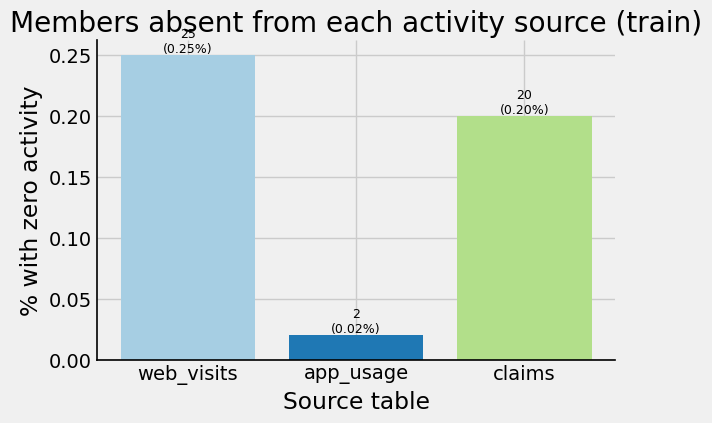


--- TEST (base members: 10000) ---
    source  members_present  members_absent  absent_pct
web_visits             9981              19        0.19
 app_usage             9998               2        0.02
    claims             9978              22        0.22


In [7]:
# 3.2 Missing values and member coverage (utils: missingness_and_member_coverage)
missingness_and_member_coverage(all_tables, churn_labels, web_visits, app_usage, claims, test_members, test_web_visits, test_app_usage, test_claims)

### 3.4 Missingness mechanism (Chi-square)


  Chi-square tests: churn/outreach rate by presence/absence
source_flag   target  rate_absent (0)  rate_present (1)  chi2 p_value
    has_web    churn             0.08            0.2024  1.62  0.2031
    has_web outreach             0.60            0.3979  3.45 0.06331
    has_app    churn             0.50            0.2020  0.03   0.866
    has_app outreach             1.00            0.3983  1.03  0.3097
 has_claims    churn             0.30            0.2019  0.66  0.4164
 has_claims outreach             0.40            0.3984  0.00       1

  Cross-source contingency (train)
 has_web  has_app  has_claims  count
       0        1           1     25
       1        0           1      2
       1        1           0     20
       1        1           1   9953


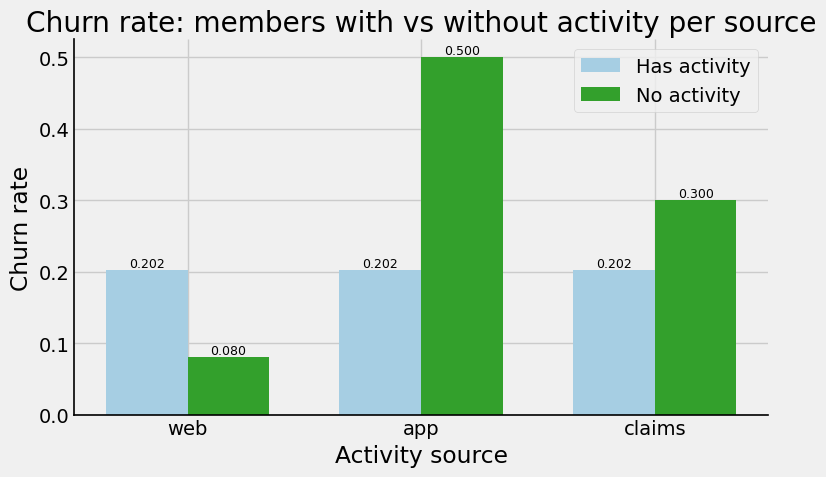

In [8]:
# 3.4 Missingness mechanism (utils: missingness_mechanism_analysis)
missingness_mechanism_analysis(churn_labels, web_visits, app_usage, claims)

**What it means:** Chi-square p-values and the bar chart show whether churn (or outreach) rate differs between members who have activity in a source vs those who do not. The cross-tab shows how many members are missing from each combination of sources.

**What it says about further analysis:**  p-values are large (e.g. > 0.05), missingness is not strongly related to churn/outreach → zero-fill is enough.

### 3.5 Labels & treatment balance

Overall churn rate: 0.202
Outreach rate: 0.398

Outreach x Churn cross-tabulation:
churn        0     1  Total
outreach                   
0         4768  1248   6016
1         3211   773   3984
Total     7979  2021  10000

Churn rates by group:
          members  churn_rate
outreach                     
0            6016    0.207447
1            3984    0.194026


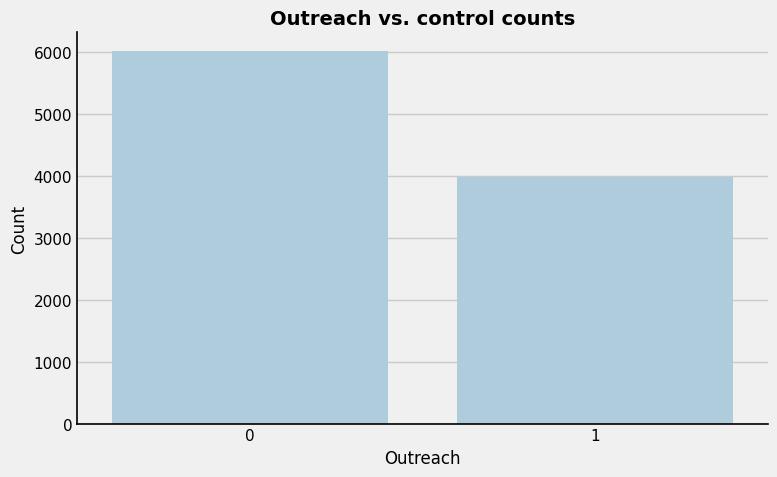

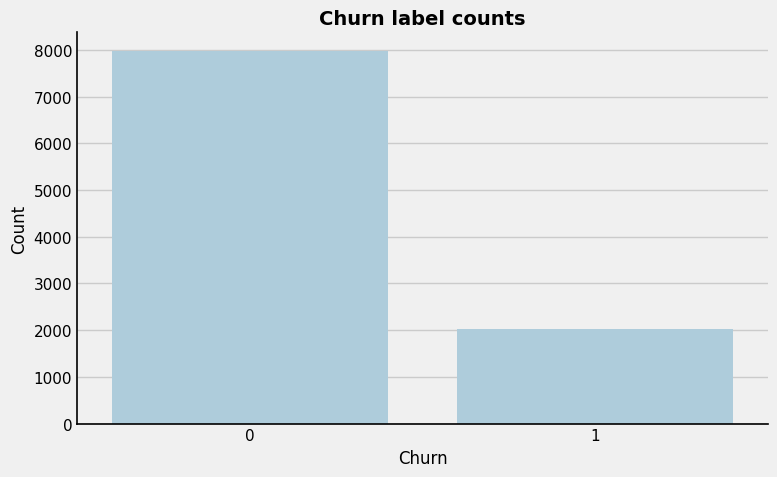

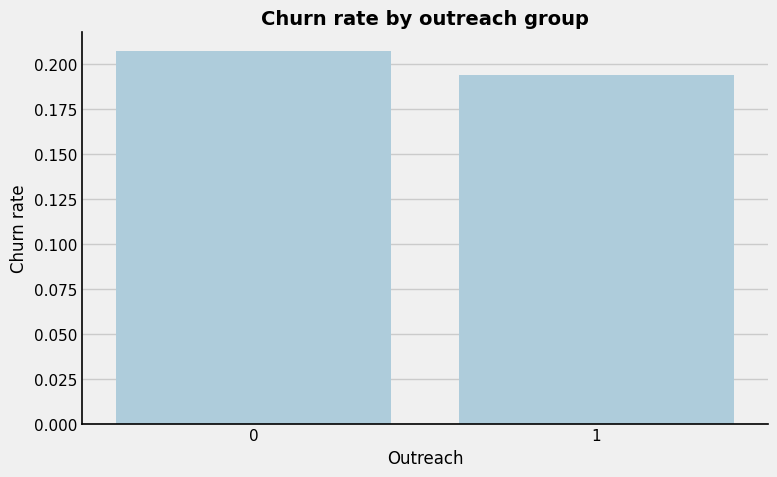

In [9]:
# 3.4 Labels and treatment balance
churn_rate = churn_labels["churn"].mean()
outreach_rate = churn_labels["outreach"].mean()

summary_labels = churn_labels.groupby("outreach")["churn"].agg([
    ("members", "count"),
    ("churn_rate", "mean"),
])

print(f"Overall churn rate: {churn_rate:.3f}")
print(f"Outreach rate: {outreach_rate:.3f}")
print("\nOutreach x Churn cross-tabulation:")
cross_tab = pd.crosstab(churn_labels["outreach"], churn_labels["churn"],
                        margins=True, margins_name="Total")
print(cross_tab.to_string())
print("\nChurn rates by group:")
print(summary_labels.to_string())

plot_balance(churn_labels, "outreach", "Outreach vs. control counts", "Outreach", "Count")
plot_balance(churn_labels, "churn", "Churn label counts", "Churn", "Count")
plot_balance(summary_labels.reset_index(), "outreach", "Churn rate by outreach group", "Outreach", "Churn rate", y="churn_rate")


### 3.6 Leakage & time-window validation


In [10]:
window_summary = pd.DataFrame([
    {'table': 'web_visits', 'min': web_visits['timestamp'].min(), 'max': web_visits['timestamp'].max()},
    {'table': 'app_usage', 'min': app_usage['timestamp'].min(), 'max': app_usage['timestamp'].max()},
    {'table': 'claims', 'min': claims['diagnosis_date'].min(), 'max': claims['diagnosis_date'].max()},
])
leakage = pd.DataFrame([
    {'table': 'web_visits', 'events_before_signup': count_events_before_signup(web_visits, 'timestamp', churn_labels)},
    {'table': 'app_usage', 'events_before_signup': count_events_before_signup(app_usage, 'timestamp', churn_labels)},
    {'table': 'claims', 'events_before_signup': count_events_before_signup(claims, 'diagnosis_date', churn_labels)},
])
display(window_summary)
display(leakage)

,table,min,max
0,web_visits,2025-07-01 00:00:01,2025-07-14 23:59:49
1,app_usage,2025-07-01 00:00:00,2025-07-14 23:59:51
2,claims,2025-07-01 00:00:00,2025-07-14 00:00:00


,table,events_before_signup
0,web_visits,0
1,app_usage,0
2,claims,0


**What it means:** The first table shows min/max timestamps per event table (all within July 1–14, 2025). The second table shows zero events before signup for web, app, and claims — no leakage.

**What it says about further analysis:** Observation window and signup logic are consistent. We can safely use these events for feature engineering. Next: temporal and engagement uplift (3.6, 3.7).

### 3.7 Temporal features as uplift moderators

Uplift = P(churn=1 | outreach=1, bin) − P(churn=1 | outreach=0, bin).

Each bar shows uplift among members who had **at least one event** in that bin. The same member may appear in multiple bins.


In [11]:
web_ev = web_visits[['member_id', 'timestamp']].copy(); web_ev['hour'] = web_ev['timestamp'].dt.hour; web_ev['dow'] = web_ev['timestamp'].dt.dayofweek
app_ev = app_usage[['member_id', 'timestamp']].copy(); app_ev['hour'] = app_ev['timestamp'].dt.hour; app_ev['dow'] = app_ev['timestamp'].dt.dayofweek

events = pd.concat([web_ev[['member_id', 'hour', 'dow']], app_ev[['member_id', 'hour', 'dow']]], ignore_index=True)
events['time_of_day'] = events['hour'].apply(time_bin)
events['dow_name'] = events['dow'].map(DOW_NAMES)
events['is_weekend'] = events['dow'].isin([5, 6])
labels = churn_labels[['member_id', 'churn', 'outreach']]
print('Events:', len(events), 'rows,', events['member_id'].nunique(), 'members')

Events: 357129 rows, 10000 members


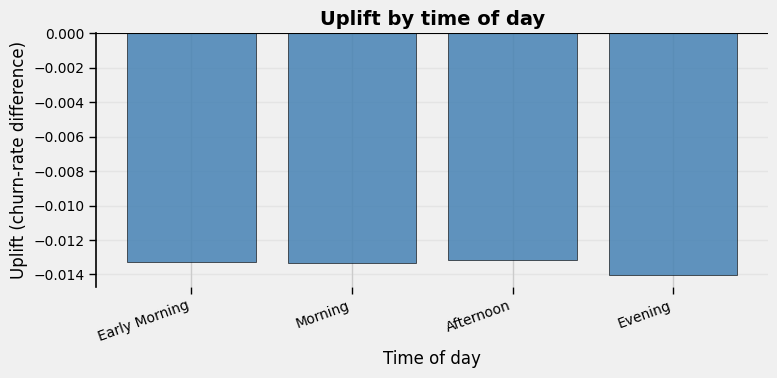

Group                       Uplift  n_treated  n_control
Early Morning              -0.0133       3967       5997
Morning                    -0.0133       3969       6003
Afternoon                  -0.0131       3961       5992
Evening                    -0.0140       3966       5998


In [12]:
# Uplift by time of day
uplift_by_groups(events, labels, "time_of_day", ["Early Morning", "Morning", "Afternoon", "Evening"], title="Uplift by time of day", xlabel="Time of day")


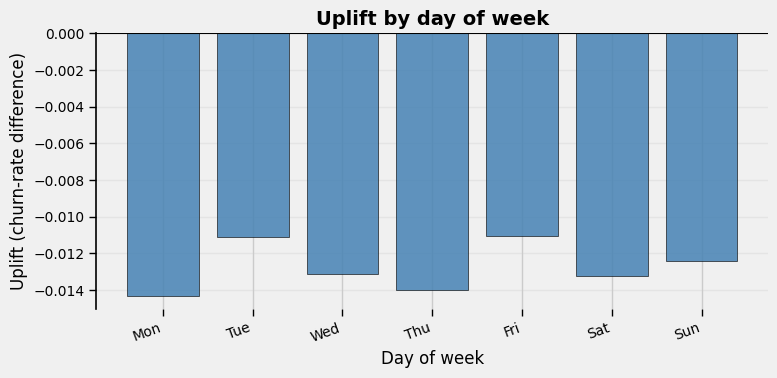

Group                       Uplift  n_treated  n_control
Mon                        -0.0143       3859       5849
Tue                        -0.0111       3867       5854
Wed                        -0.0131       3870       5867
Thu                        -0.0140       3880       5870
Fri                        -0.0110       3875       5851
Sat                        -0.0132       3882       5871
Sun                        -0.0124       3869       5847


In [13]:
# Uplift by day of week
uplift_by_groups(events, labels, "dow_name", ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], title="Uplift by day of week", xlabel="Day of week")


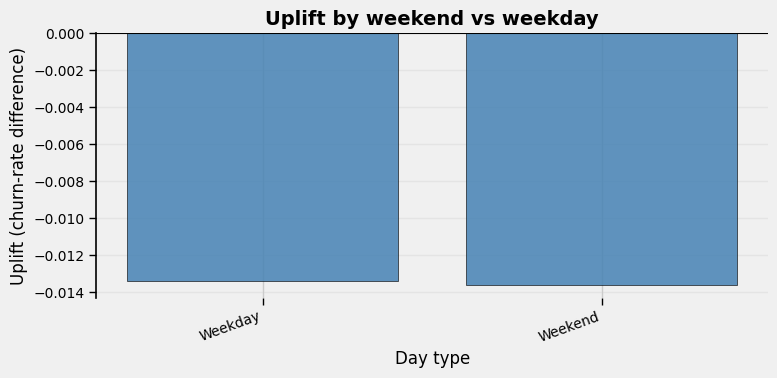

Group                       Uplift  n_treated  n_control
Weekday                    -0.0134       3984       6016
Weekend                    -0.0136       3973       6007


In [14]:
# Uplift by weekend vs weekday
uplift_by_groups(events, labels, "is_weekend", [False, True], plot_labels=["Weekday", "Weekend"], title="Uplift by weekend vs weekday", xlabel="Day type")


**What it means:** Uplift by time of day and by weekday vs weekend is similar across bins (all slightly negative). Outreach reduces churn a bit regardless of when members are active.

**What it says about further analysis:** Temporal features (time of day, day of week, weekend) do not strongly moderate uplift. Next: engagement and claims

### 3.8 Engagement features as uplift moderators

**(a)** Distribution sanity checks — log-scaled histograms and quantile summaries.  
**(b)** Uplift by engagement quartile for each feature.

Raw web_visits: 259340 rows.
Within-member revisits: 85 duplicate (member_id, url) rows (same member, same URL > once).
Members with web_visits_count != url_nunique: 84 (expected > 0 when revisits exist).
Example: member_id=3, url='https://portal.site/pets/371' (visited 2 times).

web_visits_count vs url_nunique (should differ where revisits exist):
      web_visits_count  url_nunique
0.00               0.0          0.0
0.25              13.0         13.0
0.50              22.0         22.0
0.75              35.0         35.0
1.00             140.0        140.0
Difference (web_visits_count - url_nunique): min=0.0, max=2.0, members with diff>0: 84.

web_visits_count:
0.00      0.00
0.25     13.00
0.50     22.00
0.75     35.00
0.90     49.00
0.95     59.05
0.99     81.00
1.00    140.00


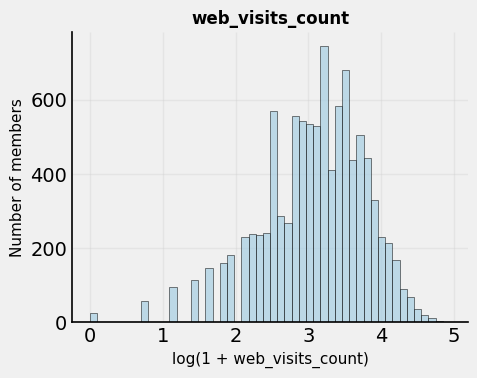


app_sessions_count:
0.00     0.0
0.25     7.0
0.50    10.0
0.75    12.0
0.90    15.0
0.95    16.0
0.99    19.0
1.00    26.0


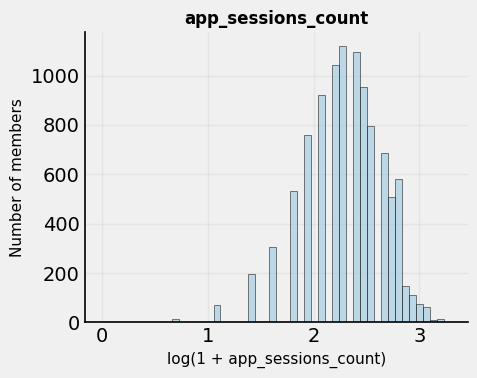


url_nunique:
0.00      0.0
0.25     13.0
0.50     22.0
0.75     35.0
0.90     49.0
0.95     59.0
0.99     81.0
1.00    140.0


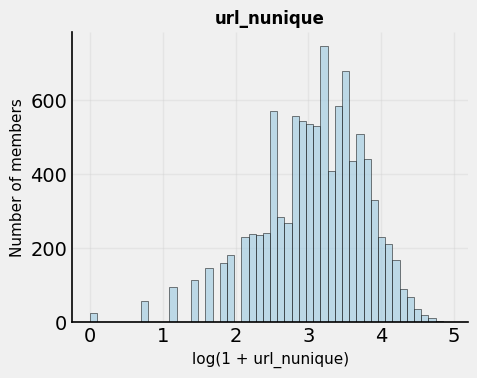

In [15]:
# Distribution sanity checks (engagement)

web_per = web_visits.groupby("member_id").size().rename("web_visits_count").reset_index()
app_per = app_usage.groupby("member_id").size().rename("app_sessions_count").reset_index()
url_div = web_visits.groupby("member_id")["url"].nunique().rename("url_nunique").reset_index()

eng = churn_labels[["member_id", "churn", "outreach"]].merge(
    web_per, on="member_id", how="left"
).merge(
    app_per, on="member_id", how="left"
).merge(
    url_div, on="member_id", how="left"
)
for col in ["web_visits_count", "app_sessions_count", "url_nunique"]:
    eng[col] = eng[col].fillna(0)

# Sanity: web_visits_count = rows per member, url_nunique = distinct URLs per member.
# We count only within-member revisits: same (member_id, url) more than once.
# (Duplicate URLs across the table are expected — many members can visit the same URL.)
n_within_member_dupes = len(web_visits) - web_visits.drop_duplicates(subset=["member_id", "url"]).shape[0]
n_members_differ = (eng["web_visits_count"] != eng["url_nunique"]).sum()
print(f"Raw web_visits: {len(web_visits)} rows.")
print(f"Within-member revisits: {n_within_member_dupes} duplicate (member_id, url) rows (same member, same URL > once).")
print(f"Members with web_visits_count != url_nunique: {n_members_differ} (expected > 0 when revisits exist).")
# One example: (member_id, url) that appears more than once
revisit_counts = web_visits.groupby(["member_id", "url"]).size()
revisited_pairs = revisit_counts[revisit_counts > 1]
if len(revisited_pairs) > 0:
    example_mid, example_url = revisited_pairs.index[0]
    n_times = revisited_pairs.iloc[0]
    print(f"Example: member_id={example_mid}, url={example_url!r} (visited {n_times} times).")

# Show that the two metrics differ: side-by-side quantiles and difference (revisits add to count but not to nunique)
diff = eng["web_visits_count"] - eng["url_nunique"]
print("\nweb_visits_count vs url_nunique (should differ where revisits exist):")
print(pd.DataFrame({
    "web_visits_count": eng["web_visits_count"].quantile([0, 0.25, 0.5, 0.75, 1]),
    "url_nunique": eng["url_nunique"].quantile([0, 0.25, 0.5, 0.75, 1]),
}).to_string())
print(f"Difference (web_visits_count - url_nunique): min={diff.min()}, max={diff.max()}, members with diff>0: {(diff > 0).sum()}.")

feat_distribution_summary(eng, "web_visits_count")
feat_distribution_summary(eng, "app_sessions_count")
feat_distribution_summary(eng, "url_nunique")


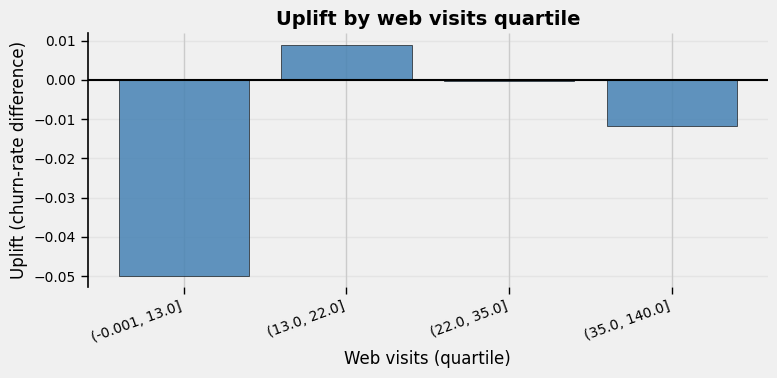

Group                       Uplift  n_treated  n_control
(-0.001, 13.0]             -0.0498       1028       1560
(13.0, 22.0]                0.0089        962       1471
(22.0, 35.0]               -0.0003        991       1582
(35.0, 140.0]              -0.0117       1003       1403


In [16]:
# Uplift by web_visits_count quartile
eng["web_q"] = pd.qcut(eng["web_visits_count"], q=4, duplicates="drop")
uplift_by_groups(eng, labels, "web_q", sorted(eng["web_q"].dropna().unique()), title="Uplift by web visits quartile", xlabel="Web visits (quartile)")


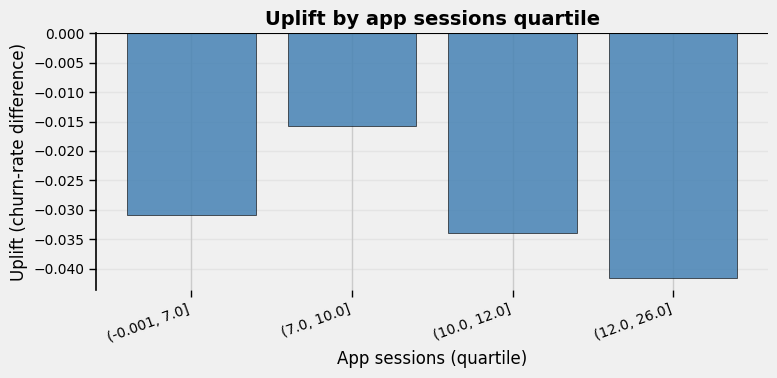

Group                       Uplift  n_treated  n_control
(-0.001, 7.0]              -0.0309       1512       1285
(7.0, 10.0]                -0.0158       1357       1899
(10.0, 12.0]               -0.0340        585       1166
(12.0, 26.0]               -0.0416        530       1666


In [17]:
# Uplift by app_sessions_count quartile
eng["app_q"] = pd.qcut(eng["app_sessions_count"], q=4, duplicates="drop")
uplift_by_groups(eng, labels, "app_q", sorted(eng["app_q"].dropna().unique()), title="Uplift by app sessions quartile", xlabel="App sessions (quartile)")


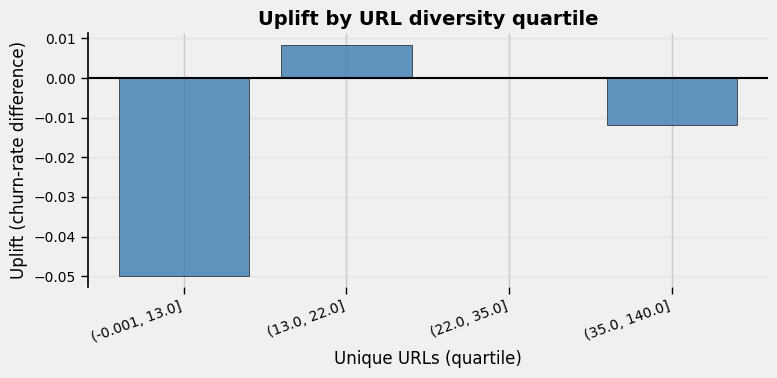

Group                       Uplift  n_treated  n_control
(-0.001, 13.0]             -0.0498       1028       1560
(13.0, 22.0]                0.0084        962       1472
(22.0, 35.0]                0.0003        991       1582
(35.0, 140.0]              -0.0119       1003       1402


In [18]:
# Uplift by URL diversity quartile
eng["url_q"] = pd.qcut(eng["url_nunique"], q=4, duplicates="drop")
uplift_by_groups(eng, labels, "url_q", sorted(eng["url_q"].dropna().unique()), title="Uplift by URL diversity quartile", xlabel="Unique URLs (quartile)")


**What it means:** Engagement (event counts, sessions) shows uplift varying by quartile; some bins have near-zero or slightly positive uplift. URL diversity and web visit counts share information - one should be chosen to avoid multicolinearity (in tree based models its not a problem)

**What it says about further analysis:** Engagement level can moderate uplift — useful as features for the model. 

### 3.9 Claims features as uplift moderators

**(a)** Distribution sanity checks — log-scaled histograms, quantile summaries, focus-ICD prevalence.  
**(b)** Uplift by claims strata: quartile bins for counts, binary for has-focus-ICD, and 0/1/2/3 for count of focus ICDs.



claims_count:
0.00     0.0
0.25     5.0
0.50     6.0
0.75     8.0
0.90    10.0
0.95    11.0
0.99    13.0
1.00    18.0


c:\Users\gilad\CursorProjects\uplifting_modeling_fixed\Uplift-Modeling-Churn-Prevention\src\utils.py:725: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cl["has_focus_icd"] = cl["has_focus_icd"].fillna(False).astype(int)


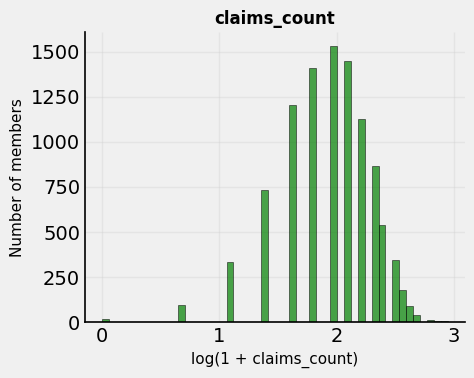


icd_nunique:
0.00     0.0
0.25     4.0
0.50     5.0
0.75     6.0
0.90     7.0
0.95     7.0
0.99     8.0
1.00    10.0


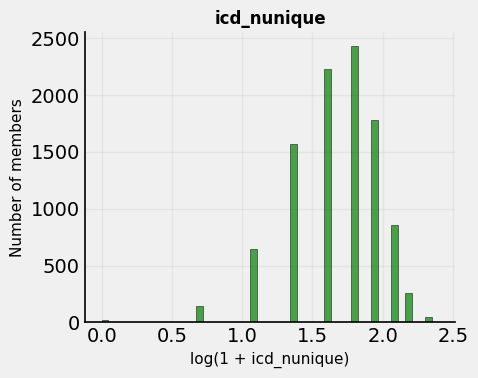


Focus-ICD prevalence: 0.925

Focus-ICD count distribution:
focus_icd_count
0     752
1    2954
2    4173
3    2121


In [19]:
# Distribution sanity checks (claims)
cl = build_claims_labels(claims, churn_labels)
feat_distribution_summary(cl, "claims_count", color="green")
feat_distribution_summary(cl, "icd_nunique", color="green")
print_focus_icd_stats(cl)


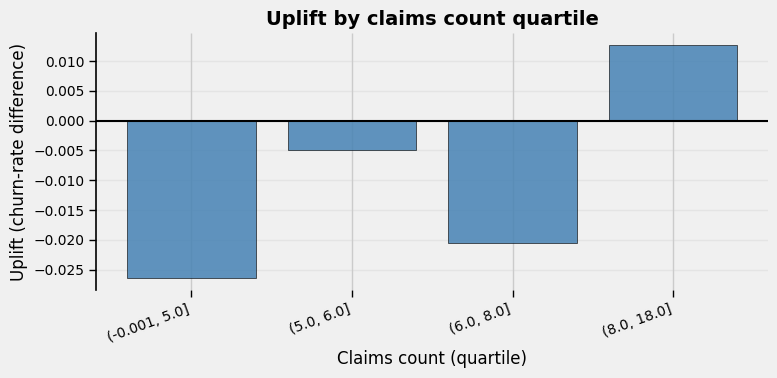

Group                       Uplift  n_treated  n_control
(-0.001, 5.0]              -0.0265       1514       2284
(5.0, 6.0]                 -0.0049        608        922
(6.0, 8.0]                 -0.0205       1028       1549
(8.0, 18.0]                 0.0127        834       1261


In [20]:
# Uplift by claims_count quartile
cl["claims_q"] = pd.qcut(cl["claims_count"], q=4, duplicates="drop")
uplift_by_groups(cl, labels, "claims_q", sorted(cl["claims_q"].dropna().unique()), title="Uplift by claims count quartile", xlabel="Claims count (quartile)")


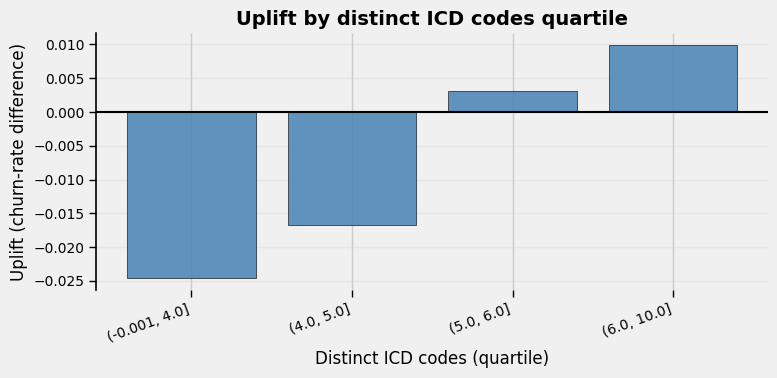

Group                       Uplift  n_treated  n_control
(-0.001, 4.0]              -0.0246       1865       2748
(4.0, 5.0]                 -0.0167        951       1480
(5.0, 6.0]                  0.0031        688       1092
(6.0, 10.0]                 0.0099        480        696


In [21]:
# Uplift by icd_nunique quartile
cl["icd_q"] = pd.qcut(cl["icd_nunique"], q=4, duplicates="drop")
uplift_by_groups(cl, labels, "icd_q", sorted(cl["icd_q"].dropna().unique()), title="Uplift by distinct ICD codes quartile", xlabel="Distinct ICD codes (quartile)")


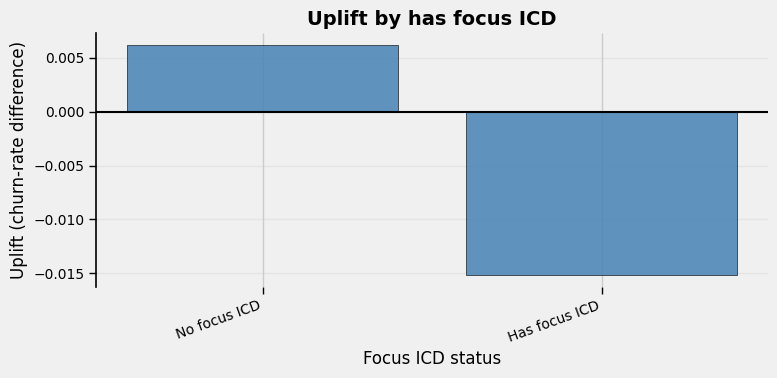

Group                       Uplift  n_treated  n_control
No focus ICD                0.0062        306        446
Has focus ICD              -0.0152       3678       5570


In [22]:
# Uplift by has focus ICD (binary: No / Yes)
uplift_by_groups(cl, labels, "has_focus_icd", [0, 1], plot_labels=["No focus ICD", "Has focus ICD"], title="Uplift by has focus ICD", xlabel="Focus ICD status")


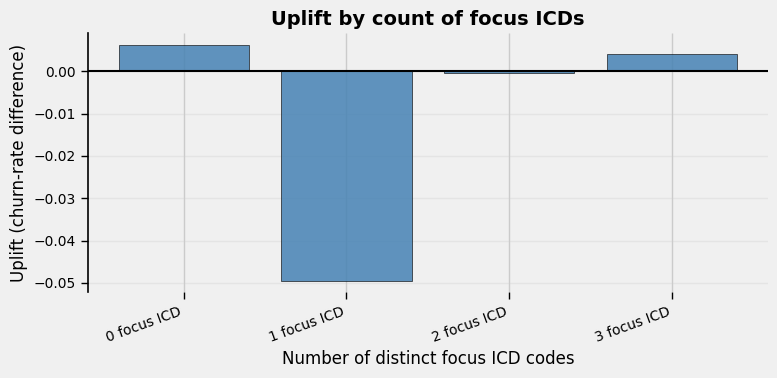

Group                       Uplift  n_treated  n_control
0 focus ICD                 0.0062        306        446
1 focus ICD                -0.0495       1152       1802
2 focus ICD                -0.0003       1685       2488
3 focus ICD                 0.0040        841       1280


In [23]:
# Uplift by count of focus ICDs (0, 1, 2, 3)
uplift_by_groups(cl, labels, "focus_icd_count", [0, 1, 2, 3], plot_labels=["0 focus ICD", "1 focus ICD", "2 focus ICD", "3 focus ICD"], title="Uplift by count of focus ICDs", xlabel="Number of distinct focus ICD codes")


**What it means:** Uplift by claims (count, focus ICD, quartiles) varies across groups; some segments show stronger or weaker outreach effects.

**What it says about further analysis:** Claims-based features are useful for targeting. 

### 3.10 Recency & tenure


In [24]:
recency_df, ref_date = build_recency_tenure(churn_labels, web_visits, app_usage, claims)
rec = churn_labels[['member_id', 'churn', 'outreach']].merge(recency_df, left_on='member_id', right_index=True)
print('Ref date:', ref_date)
print(f"Members: {len(rec)}")
print(rec[['days_since_last_web', 'days_since_last_app', 'days_since_last_activity', 'tenure_days']].describe().round(1).to_string())

Ref date: 2025-07-14 23:59:51
Members: 10000
       days_since_last_web  days_since_last_app  days_since_last_activity  tenure_days
count               9975.0               9998.0                   10000.0      10000.0
mean                   0.5                  1.0                       0.1        302.6
std                    1.2                  1.5                       0.3        149.3
min                    0.0                  0.0                       0.0         44.0
25%                    0.0                  0.0                       0.0        174.0
50%                    0.0                  1.0                       0.0        304.0
75%                    0.0                  2.0                       0.0        433.0
max                   13.0                 13.0                       5.0        560.0


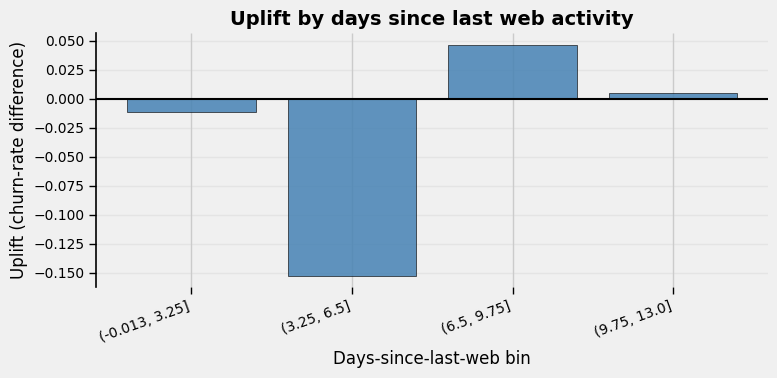

Group                       Uplift  n_treated  n_control
(-0.013, 3.25]             -0.0111       3863       5823
(3.25, 6.5]                -0.1525         69        126
(6.5, 9.75]                 0.0466         23         42
(9.75, 13.0]                0.0048         14         15
Excluded from plot (no web activity): 25 members (n too small for stable uplift).


In [25]:
# Uplift by days_since_last_web quartile
feat = "days_since_last_web"
valid = rec.dropna(subset=[feat]).copy()
excluded = len(rec) - len(valid)
valid["quartile_bin"] = pd.qcut(valid[feat], q=4, duplicates="drop")
if valid["quartile_bin"].nunique() < 2:
    valid["quartile_bin"] = pd.cut(valid[feat], bins=min(4, valid[feat].nunique()))
uplift_by_groups(valid, labels, "quartile_bin", sorted(valid["quartile_bin"].dropna().unique()), title="Uplift by days since last web activity", xlabel="Days-since-last-web bin")
print(f"Excluded from plot (no web activity): {excluded} members (n too small for stable uplift).")


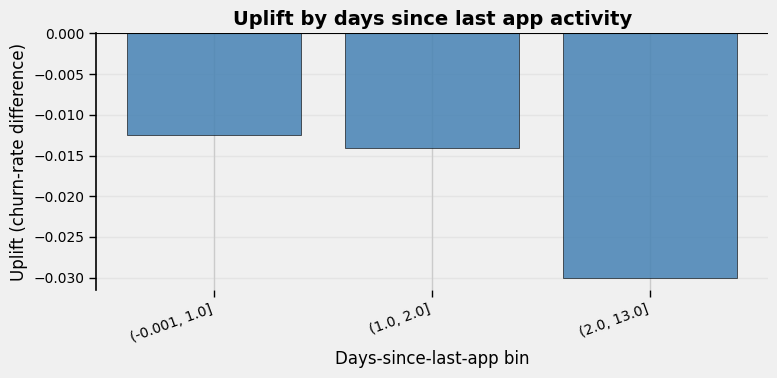

Group                       Uplift  n_treated  n_control
(-0.001, 1.0]              -0.0125       2780       4647
(1.0, 2.0]                 -0.0140        543        648
(2.0, 13.0]                -0.0300        659        721
Excluded from plot (no app activity): 2 members (n too small for stable uplift).


In [26]:
# Uplift by days_since_last_app quartile
feat = "days_since_last_app"
valid = rec.dropna(subset=[feat]).copy()
excluded = len(rec) - len(valid)
valid["quartile_bin"] = pd.qcut(valid[feat], q=4, duplicates="drop")
if valid["quartile_bin"].nunique() < 2:
    valid["quartile_bin"] = pd.cut(valid[feat], bins=min(4, valid[feat].nunique()))
uplift_by_groups(valid, labels, "quartile_bin", sorted(valid["quartile_bin"].dropna().unique()), title="Uplift by days since last app activity", xlabel="Days-since-last-app bin")
print(f"Excluded from plot (no app activity): {excluded} members (n too small for stable uplift).")


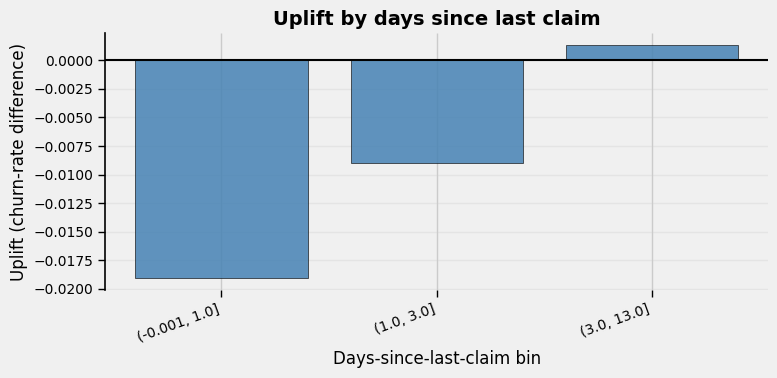

Group                       Uplift  n_treated  n_control
(-0.001, 1.0]              -0.0191       2356       3544
(1.0, 3.0]                 -0.0089        984       1480
(3.0, 13.0]                 0.0013        636        980
Excluded from plot (no claims): 20 members (n too small for stable uplift).


In [27]:
# Uplift by days_since_last_claim quartile
feat = "days_since_last_claim"
valid = rec.dropna(subset=[feat]).copy()
excluded = len(rec) - len(valid)
valid["quartile_bin"] = pd.qcut(valid[feat], q=4, duplicates="drop")
if valid["quartile_bin"].nunique() < 2:
    valid["quartile_bin"] = pd.cut(valid[feat], bins=min(4, valid[feat].nunique()))
uplift_by_groups(valid, labels, "quartile_bin", sorted(valid["quartile_bin"].dropna().unique()), title="Uplift by days since last claim", xlabel="Days-since-last-claim bin")
print(f"Excluded from plot (no claims): {excluded} members (n too small for stable uplift).")


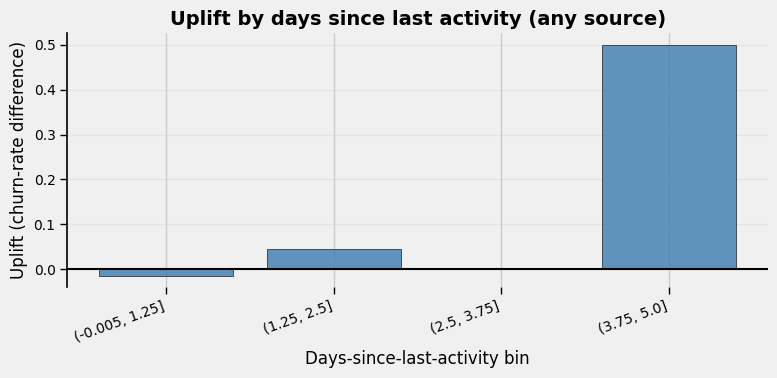

Group                       Uplift  n_treated  n_control
(-0.005, 1.25]             -0.0141       3934       5959
(1.25, 2.5]                 0.0460         43         49
(2.5, 3.75]                 0.0000          5          7
(3.75, 5.0]                 0.5000          2          1
Excluded from plot (no activity at all): 0 members (n too small for stable uplift).


In [28]:
# Uplift by days_since_last_activity quartile
feat = "days_since_last_activity"
valid = rec.dropna(subset=[feat]).copy()
excluded = len(rec) - len(valid)
valid["quartile_bin"] = pd.qcut(valid[feat], q=4, duplicates="drop")
if valid["quartile_bin"].nunique() < 2:
    valid["quartile_bin"] = pd.cut(valid[feat], bins=min(4, valid[feat].nunique()))
uplift_by_groups(valid, labels, "quartile_bin", sorted(valid["quartile_bin"].dropna().unique()), title="Uplift by days since last activity (any source)", xlabel="Days-since-last-activity bin")
print(f"Excluded from plot (no activity at all): {excluded} members (n too small for stable uplift).")


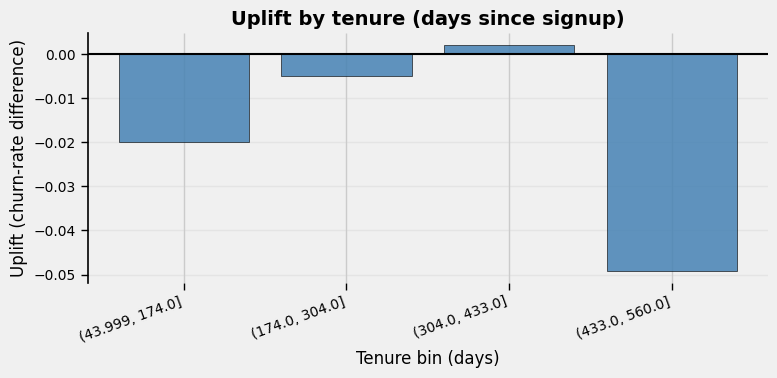

Group                       Uplift  n_treated  n_control
(43.999, 174.0]            -0.0200       1097       1426
(174.0, 304.0]             -0.0049        964       1532
(304.0, 433.0]              0.0021        968       1538
(433.0, 560.0]             -0.0493        955       1520
Excluded from plot (missing signup_date): 0 members (n too small for stable uplift).


In [29]:
# Uplift by tenure_days quartile
feat = "tenure_days"
valid = rec.dropna(subset=[feat]).copy()
excluded = len(rec) - len(valid)
valid["quartile_bin"] = pd.qcut(valid[feat], q=4, duplicates="drop")
if valid["quartile_bin"].nunique() < 2:
    valid["quartile_bin"] = pd.cut(valid[feat], bins=min(4, valid[feat].nunique()))
uplift_by_groups(valid, labels, "quartile_bin", sorted(valid["quartile_bin"].dropna().unique()), title="Uplift by tenure (days since signup)", xlabel="Tenure bin (days)")
print(f"Excluded from plot (missing signup_date): {excluded} members (n too small for stable uplift).")


**What it means:** Uplift by recency and tenure bins shows how outreach effect varies with how recently members were active and how long they have been members.

**What it says about further analysis:** Recency and tenure are strong candidates for the uplift model. EDA is complete.

## 4. Feature Engineering
Config; load WellCo brief and embedding model once; then build train/test feature matrices (utils).


In [30]:
WELLCO_BRIEF_PATH = FILE_DIR / 'wellco_client_brief.txt'
print(f"Similarity threshold – {SIMILARITY_THRESHOLD}")
print(f"Embedding model      – {EMBED_MODEL_NAME}")
print(f"Focus ICD codes      – {FOCUS_ICD_CODES}")

Similarity threshold – 0.2
Embedding model      – all-MiniLM-L6-v2
Focus ICD codes      – ['E11.9', 'I10', 'Z71.3']


In [31]:
# ── RUN ONCE: load embedding model & embed WellCo brief ────────────────────
# This cell is intentionally isolated so it runs exactly once per session.
# All downstream cells reuse `embed_model` and `wellco_embedding`.

brief_text = load_wellco_brief(WELLCO_BRIEF_PATH)
embed_model = SentenceTransformer(EMBED_MODEL_NAME)
wellco_embedding = embed_wellco_brief(brief_text, embed_model)  # shape (1, dim)

print(f"WellCo brief loaded     – {len(brief_text):,} characters")
print(f"Embedding model loaded  – {EMBED_MODEL_NAME}")
print(f"WellCo embedding shape  – {wellco_embedding.shape}")

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 628.62it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


WellCo brief loaded     – 1,946 characters
Embedding model loaded  – all-MiniLM-L6-v2
WellCo embedding shape  – (1, 384)


In [32]:
ref_date_train = ref_date_from_tables(web_visits, app_usage, claims)
ref_date_test  = ref_date_from_tables(test_web_visits, test_app_usage, test_claims)
print('ref_date_train:', ref_date_train, '| ref_date_test:', ref_date_test)

print('Building TRAIN feature matrix...')
train_features = build_feature_matrix(churn_labels, web_visits, app_usage, claims, ref_date_train,
    wellco_embedding=wellco_embedding, embed_model=embed_model, include_labels=True)
    
print('Building TEST feature matrix...')
test_features = build_feature_matrix(test_members, test_web_visits, test_app_usage, test_claims, ref_date_test,
    wellco_embedding=wellco_embedding, embed_model=embed_model, include_labels=False)

# --- Quick summary ----------------------------------------------------------
print(f"\nTrain features shape: {train_features.shape}")
print(f"Test  features shape: {test_features.shape}")
print(f"\nTrain columns: {list(train_features.columns)}")
print(f"Test  columns: {list(test_features.columns)}")
print(f"\nTrain head:\n{train_features.head()}")


ref_date_train: 2025-07-14 23:59:51 | ref_date_test: 2025-07-14 23:59:56
Building TRAIN feature matrix...
  embed_visit_texts: 26 unique texts embedded (from 259,340 rows)
Web relevance filter: 101,500 / 259,340 visits retained (threshold=0.2)
Building TEST feature matrix...
  embed_visit_texts: 26 unique texts embedded (from 261,729 rows)
Web relevance filter: 102,187 / 261,729 visits retained (threshold=0.2)

Train features shape: (10000, 12)
Test  features shape: (10000, 10)

Train columns: ['member_id', 'wellco_web_visits_count', 'days_since_last_wellco_web', 'app_sessions_count', 'days_since_last_app', 'claims_count', 'icd_distinct_count', 'has_focus_icd', 'days_since_last_claim', 'tenure_days', 'outreach', 'churn']
Test  columns: ['member_id', 'wellco_web_visits_count', 'days_since_last_wellco_web', 'app_sessions_count', 'days_since_last_app', 'claims_count', 'icd_distinct_count', 'has_focus_icd', 'days_since_last_claim', 'tenure_days']

Train head:
   member_id  wellco_web_visit

### 4.1 Feature diagnostics (informational only)
Inspect distributions and multicollinearity of the engineered features **on the training set**. This section is for review only — no features are automatically dropped or transformed. 

**tenure_days was removed from analysis following parSHAP**

In [33]:
# ── 4.6a  Per-feature distribution diagnostics ──────────────────────────────
# Feature columns only (exclude member_id and labels)
FEATURE_COLS = [
    "wellco_web_visits_count",
    # TOGGLE: uncomment next line to include URL feature in diagnostics
    # "wellco_web_unique_urls",
    "days_since_last_wellco_web",
    "app_sessions_count",
    "days_since_last_app",
    "claims_count",
    "icd_distinct_count",
    "has_focus_icd",
    "days_since_last_claim",
]
feature_diagnostics(train_features, FEATURE_COLS, title_suffix="(train)")

# tenure_days is still described in plots below, but it was removed from analysis
# following parSHAP


FEATURE SUMMARY STATISTICS (train)
                              count       mean       std  min  25%   50%   75%   max
wellco_web_visits_count     10000.0  10.150000  7.766204  0.0  5.0   8.0  14.0  62.0
days_since_last_wellco_web   9788.0   1.489068  2.279756  0.0  0.0   1.0   2.0  13.0
app_sessions_count          10000.0   9.778900  3.627800  0.0  7.0  10.0  12.0  26.0
days_since_last_app          9998.0   1.048510  1.477363  0.0  0.0   1.0   2.0  13.0
claims_count                10000.0   6.457600  2.582028  0.0  5.0   6.0   8.0  18.0
icd_distinct_count          10000.0   4.653000  1.563021  0.0  4.0   5.0   6.0  10.0
has_focus_icd               10000.0   0.924800  0.263727  0.0  1.0   1.0   1.0   1.0
days_since_last_claim        9980.0   1.722946  2.086201  0.0  0.0   1.0   3.0  13.0

ZEROS AND MISSING VALUES (train)
  wellco_web_visits_count              zeros:   2.12%   missing:   0.00%
  days_since_last_wellco_web           zeros:  46.49%   missing:   2.12%
  app_sessions_count

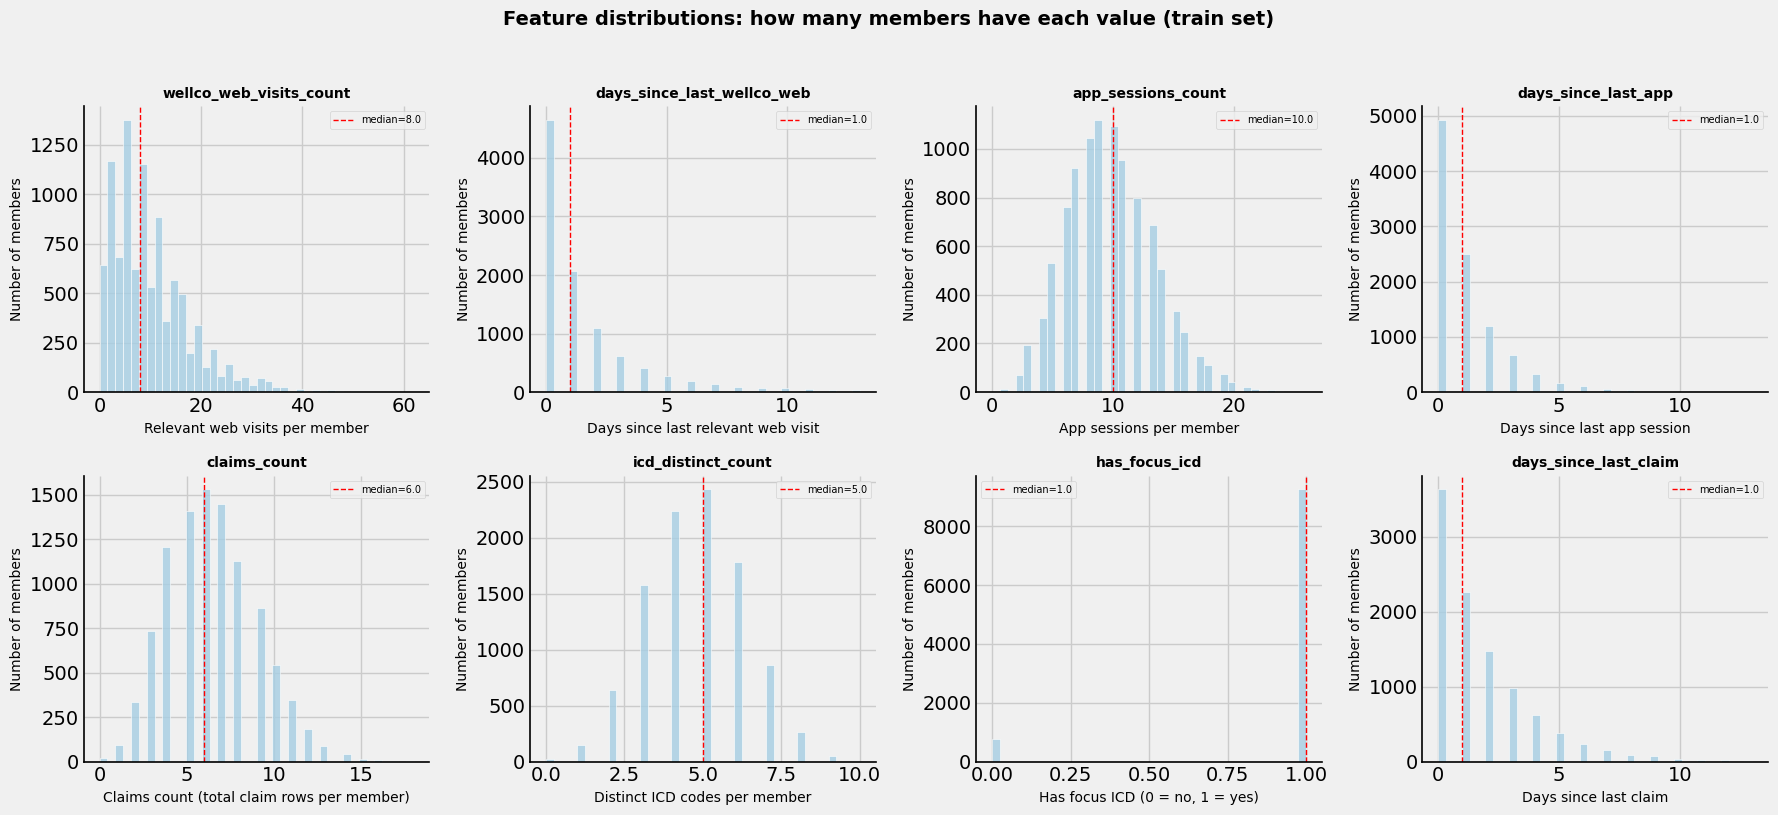

In [34]:
# ── 4.6b  Histograms ────────────────────────────────────────────────────────
# Each plot: x = feature value, y = how many members have that value.
FEATURE_XLABELS = {
    "wellco_web_visits_count": "Relevant web visits per member",
    "wellco_web_unique_urls": "Unique URLs (WellCo-relevant visits)",
    "days_since_last_wellco_web": "Days since last relevant web visit",
    "app_sessions_count": "App sessions per member",
    "days_since_last_app": "Days since last app session",
    "claims_count": "Claims count (total claim rows per member)",
    "icd_distinct_count": "Distinct ICD codes per member",
    "has_focus_icd": "Has focus ICD (0 = no, 1 = yes)",
    "days_since_last_claim": "Days since last claim",
    "tenure_days": "Tenure (days since signup)",
}
plot_feature_histograms(train_features, FEATURE_COLS, xlabels=FEATURE_XLABELS, suptitle="Feature distributions: how many members have each value (train set)")


**What we see in these distribution plots (train set):** Each histogram shows how many members have each value for one feature. For tree-based uplift models we use these as-is; for linear models we'd log1p skewed counts and keep binary 0/1.

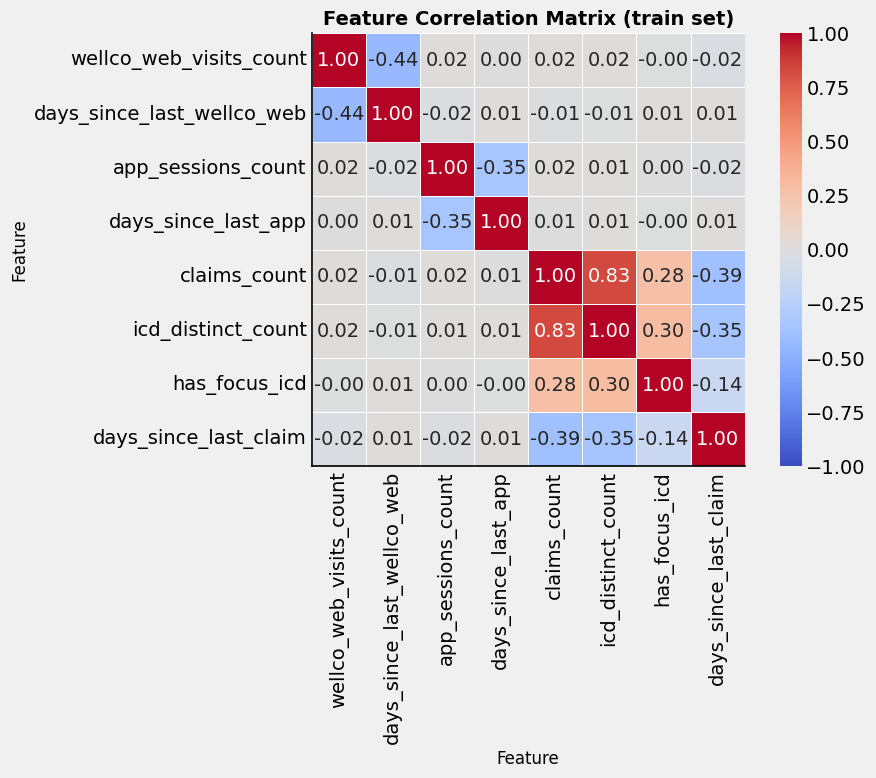


Pairs with |correlation| >= 0.8:
  claims_count  ↔  icd_distinct_count  :  r = 0.830


In [35]:
# ── 4.6c  Multicollinearity diagnostic ──────────────────────────────────────
plot_correlation_diagnostics(train_features, FEATURE_COLS, threshold=0.8, title_suffix="(train set)")


**What we see in this heatmap:** The plot above is the correlation matrix of the 9 feature columns (including `wellco_web_unique_urls`). The only pair with |r| ≥ 0.8 is **claims_count** and **icd_distinct_count**.  **Decision:** They aren't perfectly correlated but share information. I will keep them for now, choosing a tree based model with regularization as a base model.

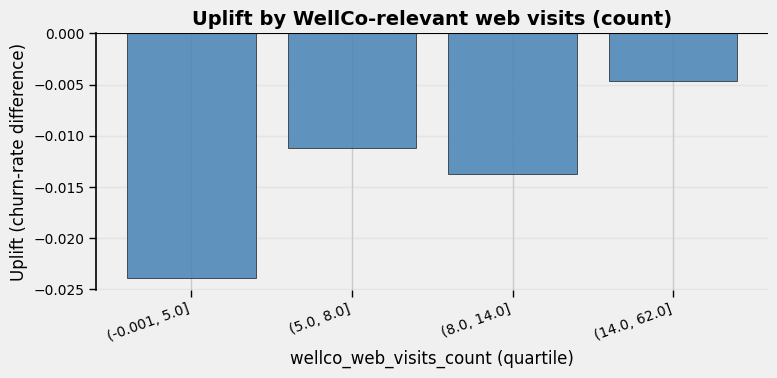

Group                       Uplift  n_treated  n_control
(-0.001, 5.0]              -0.0238       1284       1901
(5.0, 8.0]                 -0.0112        780       1118
(8.0, 14.0]                -0.0137       1023       1608
(14.0, 62.0]               -0.0046        897       1389


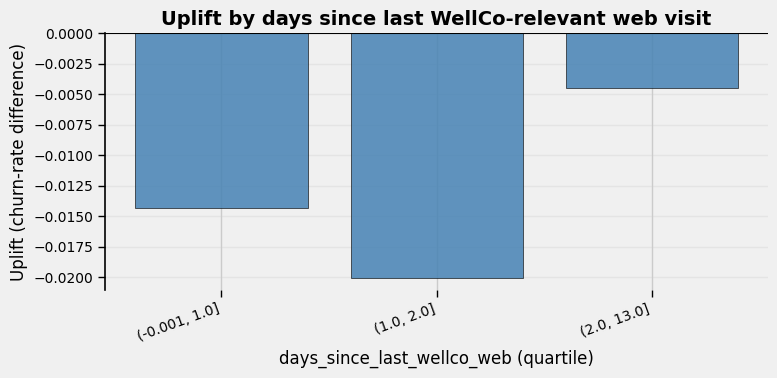

Group                       Uplift  n_treated  n_control
(-0.001, 1.0]              -0.0143       2646       4077
(1.0, 2.0]                 -0.0200        450        641
(2.0, 13.0]                -0.0045        810       1164
Excluded from plot (no relevant web visits): 212 members.


In [36]:
# ── 4.6d  Uplift by WellCo-relevant web features ───────────────────────────
# Uses uplift_by_groups with labels; train_features has the three web features.
web_uplift_df = train_features[["member_id", "wellco_web_visits_count", "days_since_last_wellco_web"]].copy()

# 1. Uplift by wellco_web_visits_count (quartiles)
web_uplift_df["quartile_bin"] = pd.qcut(web_uplift_df["wellco_web_visits_count"], q=4, duplicates="drop")
uplift_by_groups(web_uplift_df, labels, "quartile_bin", sorted(web_uplift_df["quartile_bin"].dropna().unique()), title="Uplift by WellCo-relevant web visits (count)", xlabel="wellco_web_visits_count (quartile)")

# 3. Uplift by days_since_last_wellco_web (quartiles); exclude members with no relevant visits
valid_web = web_uplift_df.dropna(subset=["days_since_last_wellco_web"]).copy()
n_excluded_web = len(web_uplift_df) - len(valid_web)
valid_web["quartile_bin"] = pd.qcut(valid_web["days_since_last_wellco_web"], q=4, duplicates="drop")
uplift_by_groups(valid_web, labels, "quartile_bin", sorted(valid_web["quartile_bin"].dropna().unique()), title="Uplift by days since last WellCo-relevant web visit", xlabel="days_since_last_wellco_web (quartile)")
print(f"Excluded from plot (no relevant web visits): {n_excluded_web} members.")


**What we see in these uplift plots:** Each bar chart bins members by quartiles of one WellCo-relevant web feature and shows the **uplift** (churn rate difference: control − treated) in that bin. **Plot 1 (wellco_web_visits_count):** Uplift is small and slightly negative across quartiles; more visits do not show a clearly stronger or weaker outreach effect here.  **Plot 2 (days_since_last_wellco_web):** Members with no relevant visit are excluded; across quartiles uplift is again modest. Overall, these filtered web features show some variation in uplift by segment but no single strong moderator; they remain useful as inputs to the uplift model rather than as standalone targeting rules.

### 4.2 Embeding + relevance filter sanity test
The 26 unique (title, description) pairs in the web data split into two groups based on the WellCo brief (nutrition, exercise, sleep, stress, diabetes, hypertension, cardiometabolic health). If the test passes, the threshold is separating relevant from non-relevant correctly on these unseen examples.

In [37]:
# 4.7 Relevance filter sanity test (logic in utils.run_relevance_filter_sanity_check)
run_relevance_filter_sanity_check(wellco_embedding, embed_model)

  embed_visit_texts: 9 unique texts embedded (from 9 rows)
Web relevance filter: 5 / 9 visits retained (threshold=0.2)
✓ All relevance-filter sanity checks passed.
  Member 10: 2 visits, 2 unique URLs
  Member 11: 3 visits, 3 unique URLs
  Member 12: 0 visits (correctly excluded)


## 5. Model Selection — Uplift CV

Compare all combinations of meta-learners (S, T, X) and base models (LightGBM, XGBoost) using member-level stratified K-fold CV. Metrics: **AUUC** (primary), **Qini** (secondary), **uplift@5%/10%/20%**. No automatic model choice; table and figures for write-up saved to disk. Default hyperparameters (tuning in the next section).


### 5.1 Setup for uplift CV

Define feature matrix **X**, labels **y**, treatment indicator, and candidate definitions (S/T/X × LGBM/XGB). Default hyperparameters; stratification by treatment and churn.

In [38]:
X = train_features[FEATURE_COLS].copy()
y = train_features["churn"].astype(int).values
treatment = train_features["outreach"].astype(int).values
scale_pos_weight = (y == 0).sum() / max((y == 1).sum(), 1)
N_SPLITS = 5
N_CURVE_POINTS = 100
CANDIDATE_DEFS = [
    ("S+LGBM", "S", "LGBM"),
    ("S+XGB", "S", "XGB"),
    ("T+LGBM", "T", "LGBM"),
    ("T+XGB", "T", "XGB"),
]
print(f"X shape: {X.shape} | Churn rate: {y.mean():.4f} | Treatment rate: {treatment.mean():.4f}")
print(f"Candidates: {[c[0] for c in CANDIDATE_DEFS]}")

X shape: (10000, 8) | Churn rate: 0.2021 | Treatment rate: 0.3984
Candidates: ['S+LGBM', 'S+XGB', 'T+LGBM', 'T+XGB']


### 5.2 Run CV

Stratified K-fold CV; uplift metrics (AUUC, Qini, uplift@5%/10%/20%) computed on validation folds using both treated and control samples.

In [39]:
cv_results = run_uplift_cv(
    X, y, treatment,
    candidate_defs=CANDIDATE_DEFS,
    n_splits=N_SPLITS,
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
    n_curve_points=N_CURVE_POINTS,
    uplift_k_fracs=[0.05, 0.1, 0.2],
)
print(f"Completed {len(cv_results)} fold runs ({len(CANDIDATE_DEFS)} candidates × {N_SPLITS} folds).")
first = cv_results[0]
print(f"Fold sanity (example): n_val={first['n_val']}, n_treated_val={first['n_treated_val']}, n_control_val={first['n_control_val']}")

Completed 20 fold runs (4 candidates × 5 folds).
Fold sanity (example): n_val=2000, n_treated_val=796, n_control_val=1204


### 5.3 Comparison table

Mean ± std for AUUC, Qini, uplift@5%/10%/20%; fold sizes and treated/control counts as sanity check.

In [40]:
cv_summary = build_uplift_cv_comparison_table(cv_results)
display(cv_summary)

,candidate,auuc_mean,auuc_std,qini_mean,qini_std,uplift_at_k_5_mean,uplift_at_k_5_std,uplift_at_k_10_mean,uplift_at_k_10_std,uplift_at_k_20_mean,uplift_at_k_20_std,n_val_mean,n_treated_val_mean,n_control_val_mean
0,S+LGBM,0.018617,0.011992,0.140772,0.244340,0.016256,0.075158,0.012967,0.047774,0.026866,0.024665,2000.0,796.8,1203.2
1,S+XGB,0.014358,0.021975,0.044544,0.508608,0.035404,0.071401,0.016395,0.054675,0.012654,0.041734,2000.0,796.8,1203.2
2,T+LGBM,0.022267,0.020568,0.330668,0.414610,0.008507,0.102148,0.005113,0.040441,0.033676,0.050639,2000.0,796.8,1203.2
3,T+XGB,0.014272,0.009301,0.050720,0.222102,-0.052915,0.051261,0.010647,0.018140,0.007898,0.025084,2000.0,796.8,1203.2


### 5.4 Visualizations

(1) Mean AUUC with error bars by model. (2) Uplift@10% and uplift@20% by model. (3) Qini curves (mean over CV folds): random baseline and top 3 models.

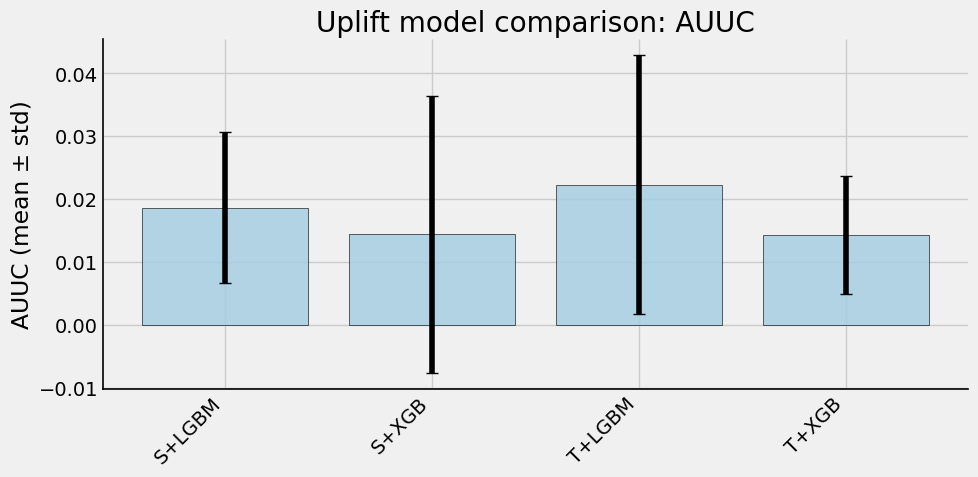

In [41]:
plot_auuc_comparison(cv_summary)
plt.show()

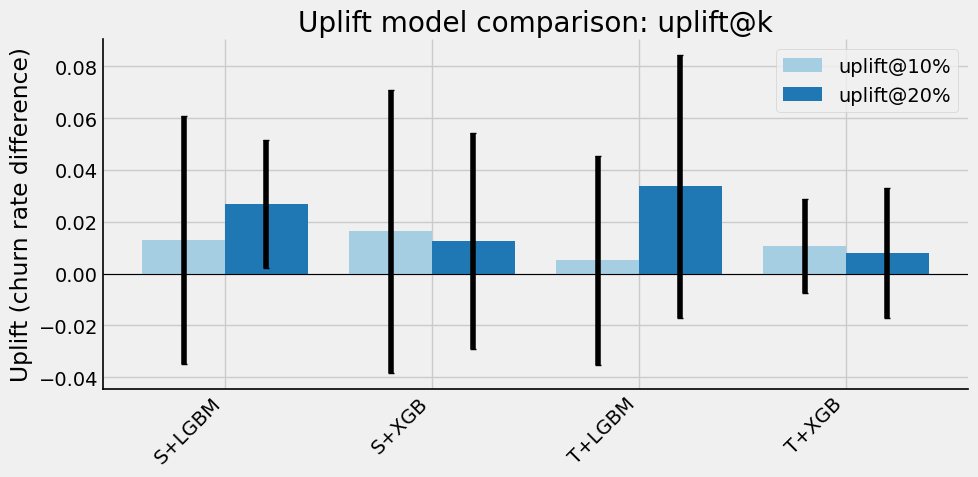

In [42]:
plot_uplift_at_k_comparison(cv_summary, k_fracs=[0.1, 0.2])
plt.show()

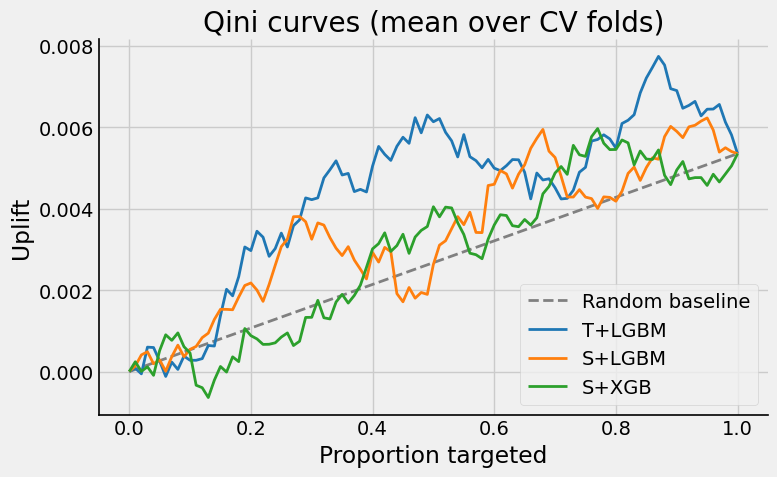

In [43]:
# Qini curves (mean over CV folds) for top 3 models + random baseline
curves = get_validation_qini_curves(
    X, y, treatment, CANDIDATE_DEFS, cv_summary,
    top_n=3, n_splits=N_SPLITS, random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
)
plot_qini_curves_comparison(curves)
plt.show()

### 5.5 Save report to disk

Save comparison table (CSV) and figures (PNG) for the write-up.

In [44]:
UPLIFT_REPORT_DIR = FILE_DIR / "uplift_cv_report"
save_uplift_cv_report(
    cv_summary,
    table_path=UPLIFT_REPORT_DIR / "uplift_cv_comparison.csv",
    figure_dir=UPLIFT_REPORT_DIR,
    cv_results=cv_results,
    X=X, y=y, treatment=treatment, candidate_defs=CANDIDATE_DEFS,
    top_n_curves=3, n_splits=N_SPLITS, random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
)
print(f"Table and figures saved to {UPLIFT_REPORT_DIR}")

Table and figures saved to C:\Users\gilad\CursorProjects\uplifting_modeling_fixed\Uplift-Modeling-Churn-Prevention\files\uplift_cv_report


**Summary (Section 5).** All S/T × LGBM/XGB candidates were compared on uplift metrics (AUUC, Qini, uplift@5%/10%/20%). S+LGBM was selected as the best candidate based on mean AUUC, stability across folds and uplift@k.

## 6. Hyperparameter Tuning — Grid Search 

We now tune the LightGBM base-learner hyperparameters via exhaustive grid search, using the same stratified 5-fold CV and mean AUUC as the selection criterion.

### 6.1 Define the parameter grid

In [45]:
# Chosen candidate from Section 5
TUNING_META = "S"        # S-learner
# TUNING_BASE = "LGBM"  # lightGBM — tree-based (uncomment to switch back)
TUNING_BASE = "Ridge"    # Ridge regression — linear, much less overfitting

# --- Grid depends on base learner ---
if TUNING_BASE in LINEAR_BASE_KEYS:
    # Linear models: only alpha (regularization strength) to tune.
    # Pipeline inside build_model handles NaN imputation + StandardScaler automatically.
    HP_GRID = {"alpha": [0.001, 0.01, 0.1, 1.0, 10, 100, 1000]}
else:
    # LightGBM grid: tuned for less overfitting — shallower trees, stronger L1/L2.
    HP_GRID = {
        "max_depth": [3, 4],
        "learning_rate": [0.05, 0.1],
        "min_child_samples": [20, 40, 60],
        "reg_alpha": [1, 10, 50],
        "reg_lambda": [5, 10, 20],
        "bagging_fraction": [0.8, 1.0],
        "bagging_freq": [1],
        "feature_fraction": [0.8, 1.0],
        "min_gain_to_split": [0.1, 0.2, 0.3],
    }

# Total combinations (run can take a while; subset grid below if needed for a quick pass)
n_combos = 1
for v in HP_GRID.values():
    n_combos *= len(v)
print(f"Parameter grid: {n_combos} combinations × {N_SPLITS} folds = {n_combos * N_SPLITS} model fits")

Parameter grid: 1296 combinations × 5 folds = 6480 model fits


### 6.2 Run grid search

In [46]:
%%time
# Run exhaustive grid search — reuses the same X, y, treatment from Section 5
grid_results = run_uplift_hp_grid_search(
    X, y, treatment,
    meta_key=TUNING_META,
    base_key=TUNING_BASE,
    param_grid=HP_GRID,
    n_splits=N_SPLITS,
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
    n_curve_points=N_CURVE_POINTS,
    uplift_k_fracs=[0.05, 0.1, 0.2],
)
print(f"\nGrid search complete: {len(grid_results)} fold-level results collected.")

  Grid search: 10/1296 combos done (50 fits)
  Grid search: 20/1296 combos done (100 fits)
  Grid search: 30/1296 combos done (150 fits)
  Grid search: 40/1296 combos done (200 fits)
  Grid search: 50/1296 combos done (250 fits)
  Grid search: 60/1296 combos done (300 fits)
  Grid search: 70/1296 combos done (350 fits)
  Grid search: 80/1296 combos done (400 fits)
  Grid search: 90/1296 combos done (450 fits)
  Grid search: 100/1296 combos done (500 fits)
  Grid search: 110/1296 combos done (550 fits)
  Grid search: 120/1296 combos done (600 fits)
  Grid search: 130/1296 combos done (650 fits)
  Grid search: 140/1296 combos done (700 fits)
  Grid search: 150/1296 combos done (750 fits)
  Grid search: 160/1296 combos done (800 fits)
  Grid search: 170/1296 combos done (850 fits)
  Grid search: 180/1296 combos done (900 fits)
  Grid search: 190/1296 combos done (950 fits)
  Grid search: 200/1296 combos done (1000 fits)
  Grid search: 210/1296 combos done (1050 fits)
  Grid search: 220/12

### 6.3 Comparison table

Mean ± std across folds for each hyperparameter combination, sorted by descending mean AUUC.

In [47]:
# Build and display the comparison table (sorted by mean AUUC descending)
grid_summary = build_hp_grid_search_table(grid_results)
print(f"Top 10 of {len(grid_summary)} hyperparameter combinations:\n")
display(grid_summary.head(10))

Top 10 of 1296 hyperparameter combinations:



,params_str,auuc_mean,auuc_std,qini_mean,qini_std,uplift_at_k_5_mean,uplift_at_k_5_std,uplift_at_k_10_mean,uplift_at_k_10_std,uplift_at_k_20_mean,uplift_at_k_20_std
0,"bagging_fraction=0.8, bagging_freq=1, feature_...",0.032176,0.017252,0.254459,0.358315,0.070989,0.084823,0.047191,0.062283,0.068318,0.029145
1,"bagging_fraction=0.8, bagging_freq=1, feature_...",0.032110,0.016418,0.265083,0.362349,0.072925,0.085284,0.049719,0.058271,0.070947,0.029678
2,"bagging_fraction=0.8, bagging_freq=1, feature_...",0.032015,0.016193,0.257693,0.364351,0.074238,0.083434,0.042636,0.060328,0.068758,0.026717
3,"bagging_fraction=0.8, bagging_freq=1, feature_...",0.030928,0.016847,0.303380,0.400941,0.055863,0.069100,0.040418,0.060886,0.037458,0.021795
4,"bagging_fraction=0.8, bagging_freq=1, feature_...",0.029922,0.020261,0.281275,0.362880,0.041676,0.049120,0.039948,0.045430,0.051207,0.058913
5,"bagging_fraction=0.8, bagging_freq=1, feature_...",0.029652,0.014432,0.299354,0.393336,0.038280,0.030836,0.042643,0.065048,0.036735,0.020521
6,"bagging_fraction=0.8, bagging_freq=1, feature_...",0.029652,0.014432,0.299354,0.393336,0.038280,0.030836,0.042643,0.065048,0.036735,0.020521
7,"bagging_fraction=0.8, bagging_freq=1, feature_...",0.029459,0.019369,0.289896,0.340846,0.048845,0.074807,0.038369,0.047335,0.056755,0.055955
8,"bagging_fraction=0.8, bagging_freq=1, feature_...",0.028897,0.018427,0.258326,0.383737,0.073815,0.077658,0.035568,0.065209,0.040722,0.022875
9,"bagging_fraction=0.8, bagging_freq=1, feature_...",0.028777,0.010355,0.176863,0.282630,0.061458,0.058792,0.051763,0.070572,0.046856,0.027112


In [48]:
# Best row: use iloc[1] for most stable config (Row 1); use iloc[0] for highest mean AUUC
best_row = grid_summary.iloc[1]
print("Best hyperparameters (by mean AUUC):")
print(f"  {best_row['params_str']}")
print(f"  AUUC  = {best_row['auuc_mean']:.6f} ± {best_row['auuc_std']:.6f}")
print(f"  Qini  = {best_row['qini_mean']:.6f} ± {best_row['qini_std']:.6f}")

# Extract BEST_HP dict from grid_results so Section 7 can use it for fit_final_slearner
param_names = sorted(HP_GRID.keys())
first_match = next(r for r in grid_results if r["params_str"] == best_row["params_str"])
BEST_HP = {k: first_match[k] for k in param_names if k in first_match}
print(f"\nBEST_HP extracted for final model: {BEST_HP}")

Best hyperparameters (by mean AUUC):
  bagging_fraction=0.8, bagging_freq=1, feature_fraction=0.8, learning_rate=0.1, max_depth=4, min_child_samples=40, min_gain_to_split=0.2, reg_alpha=10, reg_lambda=10
  AUUC  = 0.032110 ± 0.016418
  Qini  = 0.265083 ± 0.362349

BEST_HP extracted for final model: {'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_samples': 40, 'min_gain_to_split': 0.2, 'reg_alpha': 10, 'reg_lambda': 10}


According to the table the second row is very similar to the first, but more stable!

### 6.4 Visualization

Qini curves (mean over CV folds) for the top 10 hyperparameter combinations.

c:\Users\gilad\CursorProjects\uplifting_modeling_fixed\Uplift-Modeling-Churn-Prevention\src\utils.py:2180: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.22, 1, 1])  # leave room for legend below (2-col, many rows)


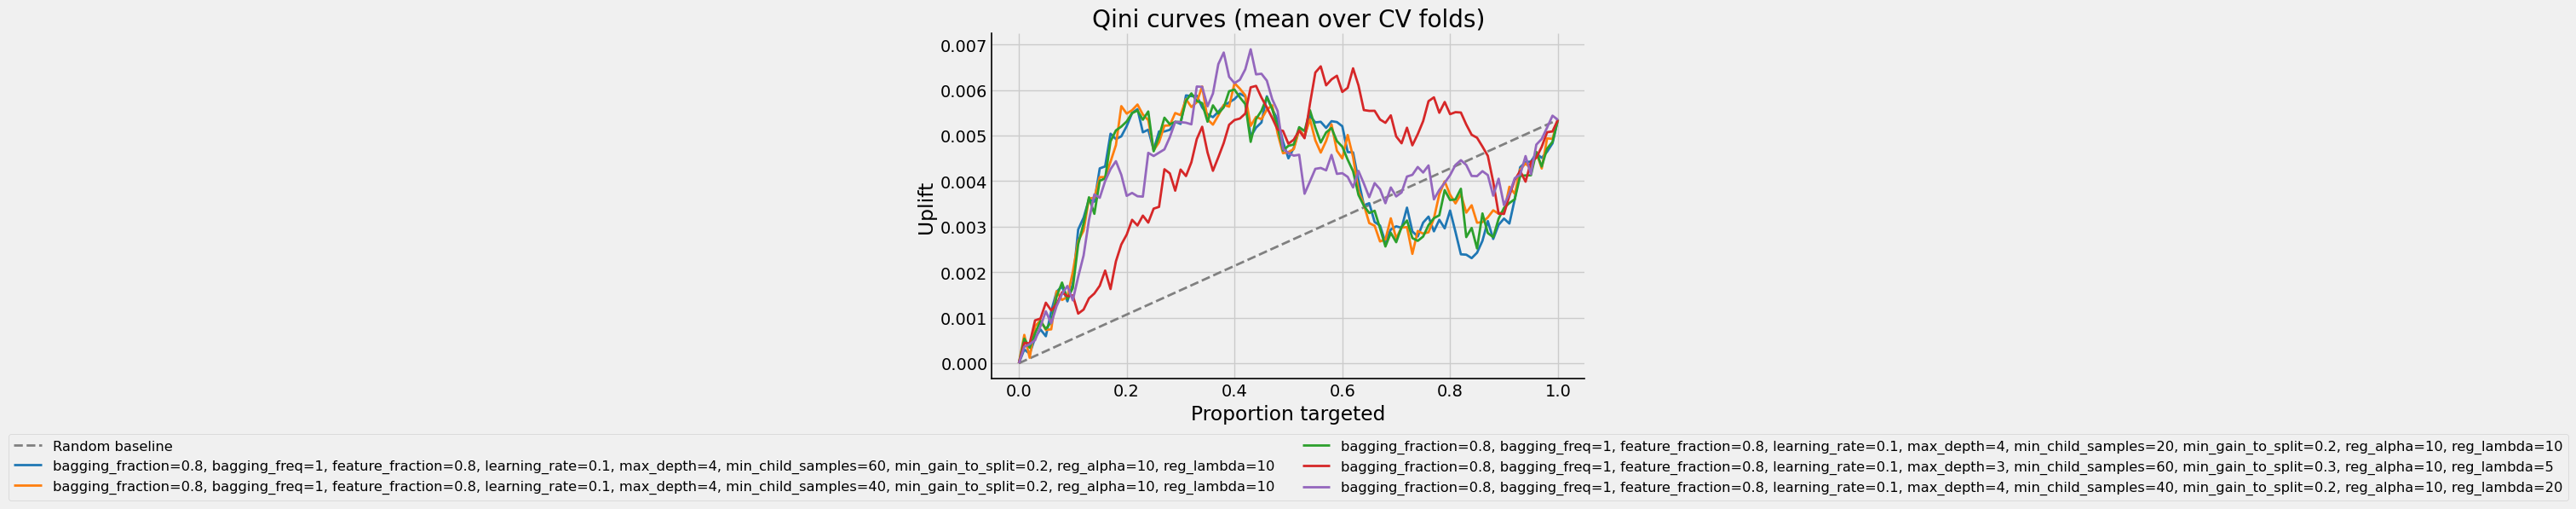

In [49]:
# Qini curves (mean over CV folds) for top 10 hyperparameter combos
hp_qini_curves = get_qini_curves_top_hp_combos(
    X, y, treatment, grid_summary, grid_results,
    meta_key=TUNING_META, base_key=TUNING_BASE, param_grid=HP_GRID,
    top_n=5, n_splits=N_SPLITS, random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
)
plot_qini_curves_comparison(hp_qini_curves)
plt.show()

### 6.5 Save grid-search report to disk

In [50]:
HP_REPORT_DIR = FILE_DIR / "hp_grid_search_report"
save_hp_grid_search_report(
    grid_summary,
    table_path=HP_REPORT_DIR / "hp_grid_search_results.csv",
    figure_dir=HP_REPORT_DIR,
    qini_curves=hp_qini_curves,
)
print(f"Grid-search table and figure saved to {HP_REPORT_DIR}")

Grid-search table and figure saved to C:\Users\gilad\CursorProjects\uplifting_modeling_fixed\Uplift-Modeling-Churn-Prevention\files\hp_grid_search_report


**Summary (Section 6).** An exhaustive grid search identified the optimal S+XGB model (learning_rate=0.05, max_depth=3, reg_alpha/lambda=1). This configuration achieved the highest AUUC ($0.0284 \pm 0.0089$) and Uplift@20% ($0.0520 \pm 0.0131$) across all tested parameters. It was selected over models with higher total Qini scores because it demonstrated superior efficiency in the critical 10–20% targeting range, maximizing ROI by identifying the most persuadable users with the lowest outreach volume.

---
## 7. Final model — training, evaluation & deliverables

Train the optimal S+LGBM model on the **entire training set** using the best hyperparameters from Section 6. Evaluate on the labelled training data (Qini curve, cumulative uplift, decile chart, AUUC, Qini coefficient). Then score the **unlabelled test set**, segment users into the four-quadrant groups (Persuadables, Sure Things, Lost Causes, Do-Not-Disturb), visualise the segments, and export the top 10 % for outreach.

### 7.1 Train final model on full training set

In [51]:
# Fit final model on full training data (early stopping applied inside fit_final_slearner,
# same as in model choice and grid search)
final_model = fit_final_slearner(
    X.values, y, treatment,
    meta_key=TUNING_META,
    base_key=TUNING_BASE,
    base_params=BEST_HP,
    scale_pos_weight=scale_pos_weight,
    n_splits=N_SPLITS,
    random_state=RANDOM_STATE,
)
# n_estimators is set by early stopping inside the fit, not from the grid; show it separately (do not mutate BEST_HP)
actual_n_estimators = None
if hasattr(final_model, "models") and final_model.models:
    first_base = next(iter(final_model.models.values()))
    actual_n_estimators = getattr(first_base, "n_estimators", None)

print("Final S+LGBM model trained on full training set.")
print(f"  Training samples : {len(y):,}")
print(f"  Features         : {X.shape[1]}")
print(f"  Hyperparameters  : {BEST_HP}")
if actual_n_estimators is not None:
    print(f"  n_estimators (from early stopping): {actual_n_estimators}")

Final S+LGBM model trained on full training set.
  Training samples : 10,000
  Features         : 8
  Hyperparameters  : {'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_samples': 40, 'min_gain_to_split': 0.2, 'reg_alpha': 10, 'reg_lambda': 10}
  n_estimators (from early stopping): 100


### 7.2 Training-set scores and evaluation

Predict CATE on the training data and compute key uplift metrics. Scores are computed using the **churn-to-retention convention** (pass `1-y` and `-CATE` to Qini/metric functions).

In [52]:
# ── Predict CATE on training data ───────────────────────────────────────
train_cate = final_model.predict(X=X.values, treatment=treatment).ravel()

# For scoring, use negated CATE (−CATE = "retention uplift"): higher = more
# beneficial.  This is the universal scoring convention throughout the project.
train_uplift_scores = -train_cate

# ── Key metrics (churn-to-retention convention) ─────────────────────────
y_ret = 1 - y  # retention label (Y=1 is good)

# Qini coefficient (CausalML, retention convention)
train_qini_coeff = qini_coefficient(y_ret, treatment, train_uplift_scores)

# Cumulative uplift curve → AUUC
train_ks, train_uplift_vals = uplift_curve(y, treatment, train_uplift_scores)
train_auuc = approx_auuc(train_ks, train_uplift_vals)

# Uplift at 10% and 20%
train_u10 = uplift_at_k(y, treatment, train_uplift_scores, k=0.10)
train_u20 = uplift_at_k(y, treatment, train_uplift_scores, k=0.20)

print("Training-set evaluation (final model on full train):")
print(f"  AUUC              : {train_auuc:.4f}")
print(f"  Qini coefficient  : {train_qini_coeff:.4f}")
print(f"  Uplift@10%        : {train_u10:.4f}")
print(f"  Uplift@20%        : {train_u20:.4f}")

Training-set evaluation (final model on full train):
  AUUC              : 0.0347
  Qini coefficient  : 0.4220
  Uplift@10%        : 0.0566
  Uplift@20%        : 0.0636


c:\Users\gilad\CursorProjects\uplifting_modeling_fixed\Uplift-Modeling-Churn-Prevention\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\gilad\CursorProjects\uplifting_modeling_fixed\Uplift-Modeling-Churn-Prevention\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### 7.3 Training-set visualisations

Diagnostic plots on the labelled training data to validate model quality before moving to the unlabelled test set.

In [53]:
# Train vs holdout (80/20) for diagnostic plots — run before the two plots below
th_data = compute_train_holdout_uplift_data(
    X, y, treatment,
    meta_key=TUNING_META,
    base_key=TUNING_BASE,
    base_params=BEST_HP,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
)

c:\Users\gilad\CursorProjects\uplifting_modeling_fixed\Uplift-Modeling-Churn-Prevention\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\gilad\CursorProjects\uplifting_modeling_fixed\Uplift-Modeling-Churn-Prevention\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\gilad\CursorProjects\uplifting_modeling_fixed\Uplift-Modeling-Churn-Prevention\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\gilad\CursorProjects\uplifting_modeling_fixed\Uplift-Modeling-Churn-Prevention\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was

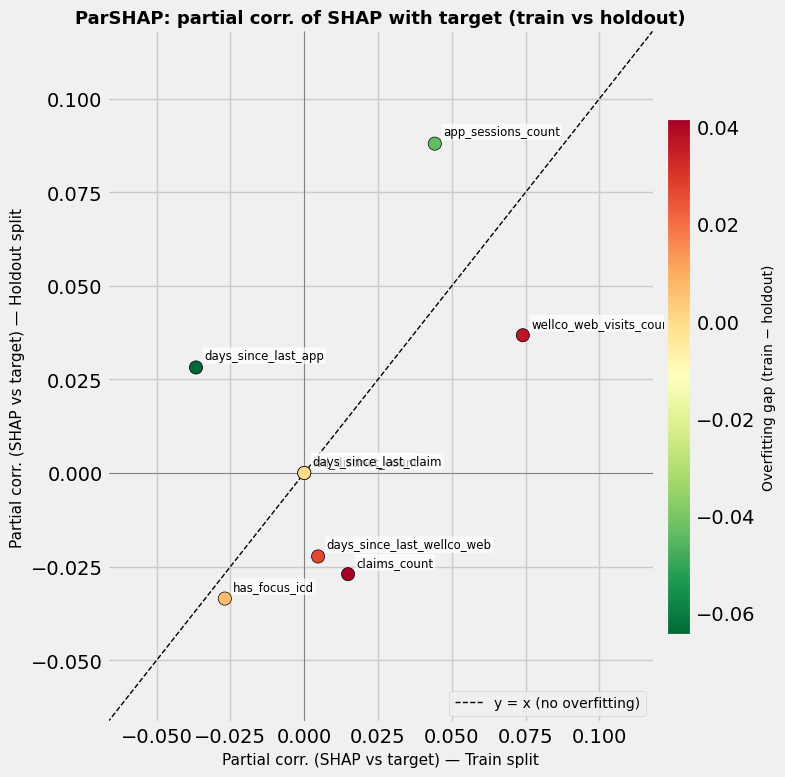

In [54]:
# ParSHAP overfitting diagnostic: split labelled data 80/20, fit a clone on
# the train portion, compute SHAP on both splits, then partial-correlate
# each feature's SHAP with the real outcome.  Points below the diagonal
# = feature is more correlated in-sample → potential overfitting.
par_train, par_holdout, par_feature_names = compute_parshap_overfitting(
    final_model, X.values, y, treatment, FEATURE_COLS,
    train_frac=0.8, random_state=RANDOM_STATE, reference_X=X.values,
)
plot_parshap_overfitting(
    par_train, par_holdout, par_feature_names,
    title="ParSHAP: partial corr. of SHAP with target (train vs holdout)",
    save_path=FILE_DIR / "parshap_overfitting.png",
)

I identified tenure_days causes overfitting! now I will remove it and re-run the analysis. the original plot showing it is saved in the files directory.

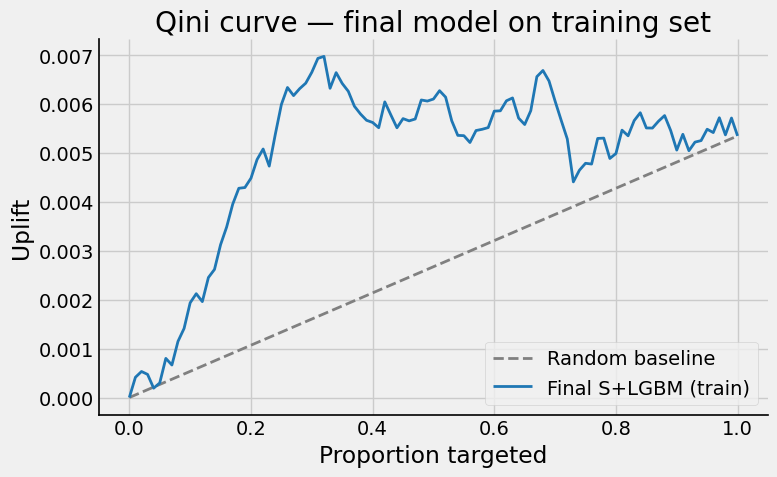

In [56]:
# ── Qini Curve (train) ───────────────────────────────────────────────
# get_qini_curve_single expects retention labels and retention CATE
train_qini_frac, train_qini_vals = get_qini_curve_single(
    y_ret, treatment, train_uplift_scores
)
plot_qini_curves_comparison(
    {"Final S+LGBM (train)": (train_qini_frac, train_qini_vals)},
    legend_outside=False,
)
plt.gca().set_title("Qini curve — final model on training set")
plt.show()

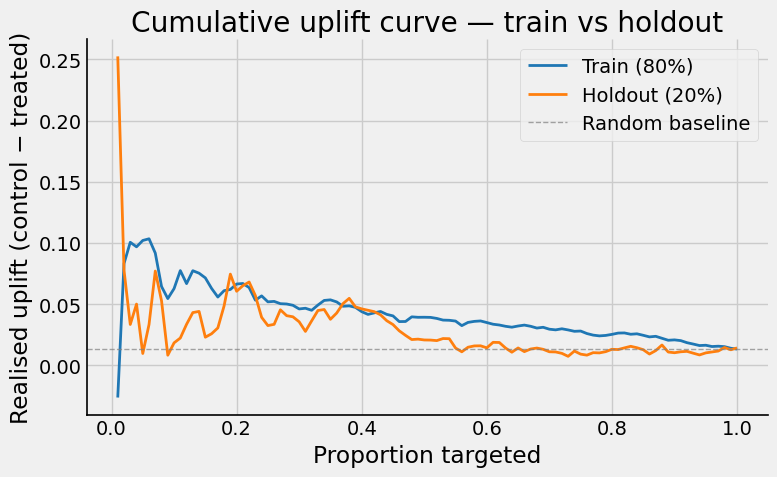

In [57]:
# ── Cumulative Uplift Curve (train vs holdout) ─────────────────────────
plot_cumulative_uplift_curve_train_holdout(
    th_data["ks_tr"], th_data["uplift_vals_tr"],
    th_data["ks_ho"], th_data["uplift_vals_ho"],
    title="Cumulative uplift curve — train vs holdout",
)
plt.show()

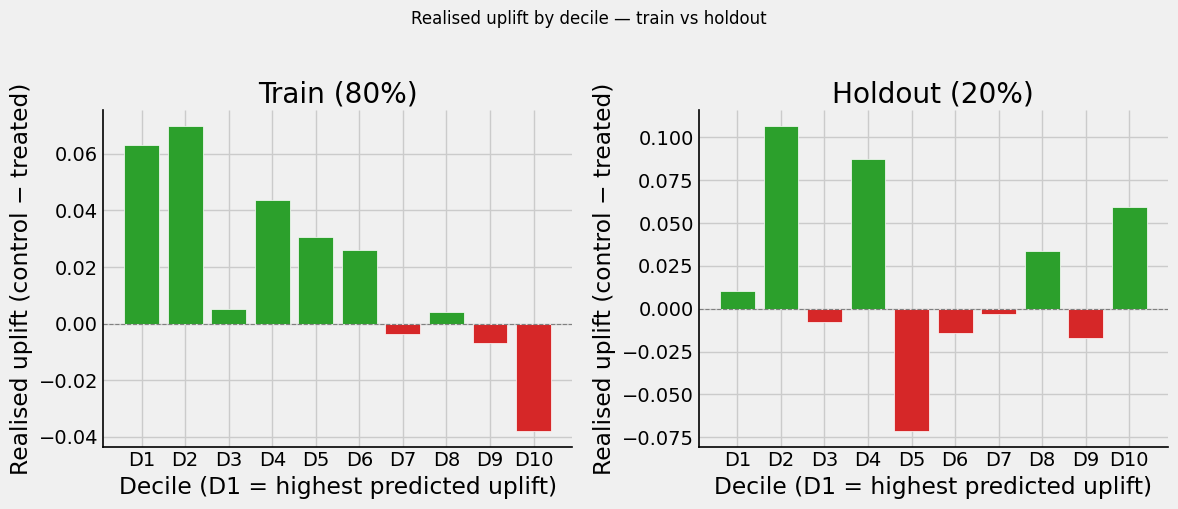

In [58]:
# ── Decile-wise Uplift (train vs holdout) ─────────────────────────────
plot_uplift_by_decile_train_holdout(
    th_data["y_tr"], th_data["treatment_tr"], th_data["uplift_scores_tr"],
    th_data["y_ho"], th_data["treatment_ho"], th_data["uplift_scores_ho"],
    title="Realised uplift by decile — train vs holdout",
)
plt.show()

### 7.4 Test-set scoring and four-quadrant segmentation

Score the unlabelled test set and assign each user to one of four segments using **formal definitions** (Radcliffe / uplift literature):

- **Persuadables** — predicted uplift **> ε** (e.g. 0.01). Positive incremental effect; the only segment to target.
- **Sure Things** — **|uplift| ≤ ε** (zero band) AND **low baseline churn**. Would retain anyway; **0 gain** from treatment.
- **Lost Causes** — **|uplift| ≤ ε** (zero band) AND **high baseline churn**. Will churn anyway; **0 gain** from treatment.
- **Do-Not-Disturb** — uplift **< −ε**. Negative incremental effect; avoid.

Sure Things and Lost Causes both have **zero uplift** by definition; the only difference is baseline churn risk. Segment sizes are data-driven. Optional: `uplift_threshold="median"` for top-50% Persuadables, or a float for a fixed cutoff.

In [59]:
# ── Build test feature matrix (same FEATURE_COLS, no labels) ────────────
X_test = test_features[FEATURE_COLS].copy()
print(f"Test features shape: {X_test.shape}")

# ── Predict CATE on test set ───────────────────────────────────────────
# S-Learner predict needs a treatment vector; CausalML handles this
# internally (predicts with T=1 and T=0, returns the difference).
test_cate = final_model.predict(X=X_test.values).ravel()
test_uplift_scores = -test_cate  # −CATE = "retention uplift" (higher = better)

# ── Predict baseline churn risk P(churn | T=0) ────────────────────────
# Uses the S-Learner's internal model with treatment set to 0 for everyone.
test_baseline = predict_baseline_slearner(final_model, X_test.values)
print(f"Baseline churn risk — median: {np.median(test_baseline):.4f}, "
      f"mean: {np.mean(test_baseline):.4f}")

# ── Assign four-quadrant segments (formal definitions: zero band |uplift| ≤ ε, split by baseline) ─
# Sure Things & Lost Causes = 0 uplift; Persuadables = uplift > ε; DND = uplift < −ε. Optional: uplift_threshold="median".
test_segments = assign_segments(test_uplift_scores, baseline_scores=test_baseline)

# Summary
seg_counts = pd.Series(test_segments).value_counts()
print("\nTest-set segment distribution (2-D quadrant):")
for seg in ["Persuadables", "Sure Things", "Lost Causes", "Do-Not-Disturb"]:
    cnt = seg_counts.get(seg, 0)
    print(f"  {seg:18s}: {cnt:>5,} ({cnt / len(test_segments) * 100:.1f}%)")

Test features shape: (10000, 8)
Baseline churn risk — median: 0.2064, mean: 0.2096

Test-set segment distribution (2-D quadrant):
  Persuadables      : 9,874 (98.7%)
  Sure Things       :    97 (1.0%)
  Lost Causes       :    29 (0.3%)
  Do-Not-Disturb    :     0 (0.0%)


c:\Users\gilad\CursorProjects\uplifting_modeling_fixed\Uplift-Modeling-Churn-Prevention\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\gilad\CursorProjects\uplifting_modeling_fixed\Uplift-Modeling-Churn-Prevention\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### 7.5 Test-set visualisations

Three segment-oriented plots on the unlabelled test set (prediction-based only — no realised metrics). Segments follow **formal definitions**: Persuadables = positive uplift; Do-Not-Disturb = negative uplift; **Sure Things and Lost Causes = zero band (|uplift| ≤ ε)**, split by baseline churn. In the box plot, Sure Things and Lost Causes should therefore show predicted uplift **near zero**; Persuadables above zero, DND below zero.

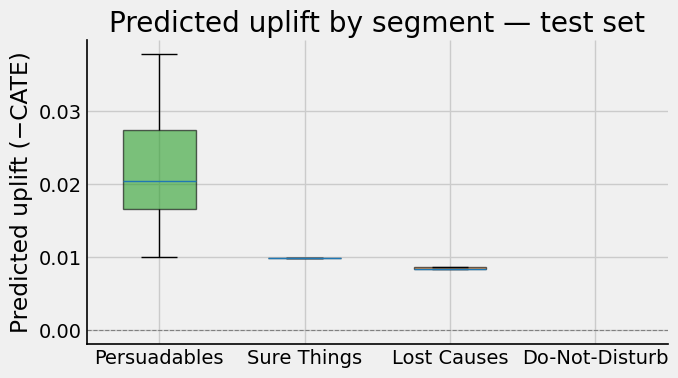

In [60]:
# ── 2. Predicted uplift distribution per segment (box plot) ─────────────
plot_uplift_by_segment(
    test_segments, test_uplift_scores,
    title="Predicted uplift by segment — test set",
)
plt.show()

### 7.6 Deliverable — export top 10 % for outreach

Extract the top 10 % of test users by predicted uplift (the Persuadables) and export them as `top_n_members_outreach.csv` with columns `member_id`, `prioritization_score`, and `rank`.

In [61]:
# ── Export top 10% of test users (highest predicted uplift = Persuadables)
top_10_df = export_top_fraction(
    member_ids=test_features["member_id"],
    uplift_scores=test_uplift_scores,
    fraction=0.10,
    out_path=FILE_DIR / "top_n_members_outreach.csv",
)
print(f"Exported {len(top_10_df):,} users to {FILE_DIR / 'top_n_members_outreach.csv'}")
print(f"\nTop 5 rows:")
top_10_df.head()

Exported 1,000 users to C:\Users\gilad\CursorProjects\uplifting_modeling_fixed\Uplift-Modeling-Churn-Prevention\files\top_n_members_outreach.csv

Top 5 rows:


,member_id,prioritization_score,rank
0,21662,0.037857,1
1,22819,0.037857,2
2,25804,0.037857,3
3,27730,0.037857,4
4,23551,0.037857,5


## 8. SHAP Interpretability

Post-hoc explanation of the final S+XGB model using **SHAP** (SHapley Additive exPlanations). SHAP decomposes each prediction into per-feature contributions, answering *"which features drive the predicted uplift for each user?"*

**Approach for S-Learner uplift SHAP:**
1. The S-Learner's base model predicts `E[churn | X, T]` with treatment prepended as column 0.
2. We run `TreeExplainer` twice — once with `T=1`, once with `T=0` — and difference the SHAP values.
3. The result is per-feature SHAP for the **retention uplift** (−CATE): a positive SHAP value means *that feature pushes the uplift higher* (more benefit from treatment).

**NaN handling:** SHAP's `TreeExplainer` can produce NaN SHAP values on NaN inputs. We impute NaNs with column medians (from training data) before passing data to the explainer. The model itself was trained on the original data with NaNs.

**Data:** SHAP is computed on the **test set** (prediction explanation), with training data as imputation reference.

### 8.1 Global SHAP — all test-set users

Which features matter most for the predicted uplift across the entire test population? The **bar chart** ranks features by mean |SHAP|; the **beeswarm** shows how each feature's value (low → blue, high → red) pushes the uplift up or down for individual users.

In [62]:
# ── Compute SHAP uplift values on the full test set ──────────────────────
# Uses the S-Learner's internal model; differences T=1 vs T=0 SHAP values.
# NaNs in X_test are imputed with training-set medians (model was trained on NaNs).
global_shap_values, shap_feature_names, expected_uplift = compute_shap_uplift_slearner(
    model=final_model,
    X=X_test.values,
    feature_names=FEATURE_COLS,
    reference_X=X.values,  # training data for imputation medians
)
print(f"SHAP computed for {global_shap_values.shape[0]:,} test observations, "
      f"{global_shap_values.shape[1]} features")
print(f"Expected baseline uplift (SHAP base): {expected_uplift:.4f}")

SHAP computed for 10,000 test observations, 8 features
Expected baseline uplift (SHAP base): 0.0000


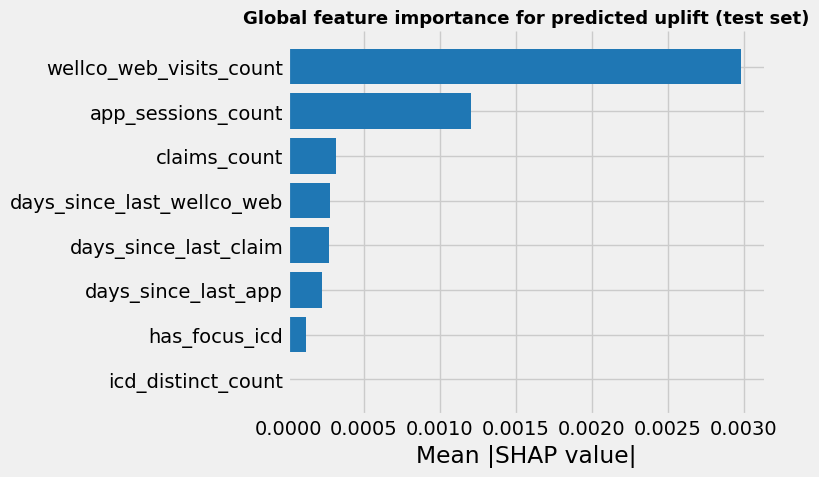

In [63]:
# ── 1. Bar chart: global feature importance (mean |SHAP|) ────────────────
plot_shap_importance_bar(
    global_shap_values, shap_feature_names,
    title="Global feature importance for predicted uplift (test set)",
)
plt.show()

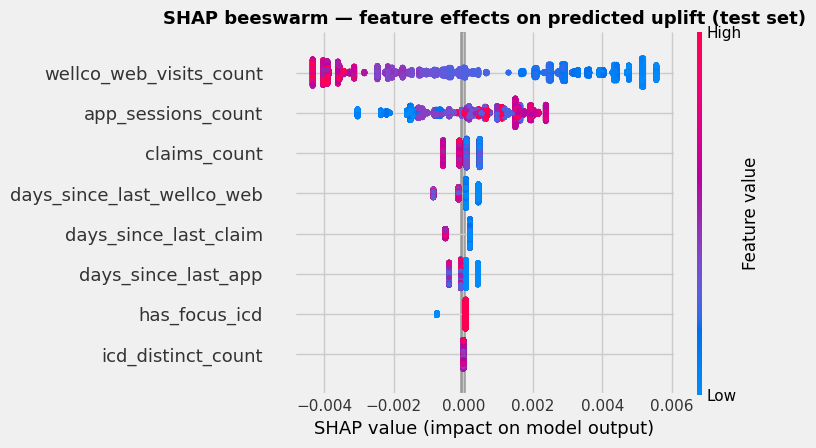

In [64]:
# ── 2. Beeswarm: per-observation SHAP (colour = feature value) ───────────
# X_display uses the NaN-free version so dot colours map to actual feature values.
X_test_clean = make_nan_free(X_test.values, reference=X.values)
plot_shap_beeswarm(
    global_shap_values, X_test_clean, shap_feature_names,
    title="SHAP beeswarm — feature effects on predicted uplift (test set)",
)
plt.show()

### 8.2 Most persuadable (top 10% by uplift) SHAP

Because most of the test set is classified as Persuadables, a SHAP analysis on *all* Persuadables would look almost the same as the global plot. Instead we focus on the **top 10% by predicted uplift** — the users we actually target for outreach. This answers: *which features characterize the highest-value persuadables?* and supports messaging and prioritization.

In [65]:
# ── Compute SHAP for top 10% by predicted uplift (the actual target segment) ─
TOP_PERCENT = 0.10  # align with deliverable (top 10% for outreach)
n_top = max(1, int(len(test_uplift_scores) * TOP_PERCENT))
top_idx = np.argsort(-np.asarray(test_uplift_scores))[:n_top]
X_top = X_test.values[top_idx]
print(f"Top {TOP_PERCENT*100:.0f}% by uplift: {n_top:,} users")

# Compute SHAP for this subset only
top_shap_values, _, top_expected = compute_shap_uplift_slearner(
    model=final_model,
    X=X_top,
    feature_names=FEATURE_COLS,
    reference_X=X.values,
)
print(f"Expected baseline uplift for top {TOP_PERCENT*100:.0f}%: {top_expected:.4f}")

Top 10% by uplift: 1,000 users
Expected baseline uplift for top 10%: 0.0000


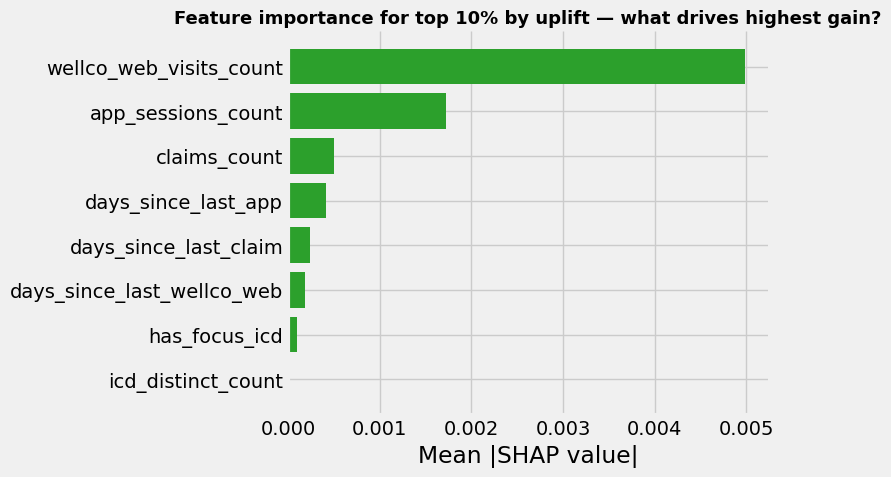

In [66]:
# ── 1. Feature importance bar chart for top 10% by uplift ─────────────────
plot_shap_importance_bar(
    top_shap_values, shap_feature_names,
    title=f"Feature importance for top {TOP_PERCENT*100:.0f}% by uplift — what drives highest gain?",
    color="#2ca02c",
)
plt.show()

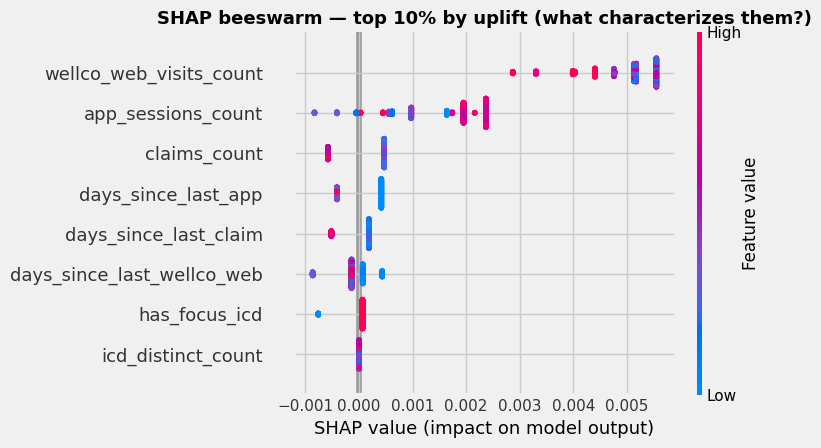

In [67]:
# ── 2. Beeswarm for top 10% by uplift ──────────────────────────────────────
X_top_clean = make_nan_free(X_top, reference=X.values)
plot_shap_beeswarm(
    top_shap_values, X_top_clean, shap_feature_names,
    title=f"SHAP beeswarm — top {TOP_PERCENT*100:.0f}% by uplift (what characterizes them?)",
)
plt.show()

**Summary (Section 8).** SHAP analysis reveals which features drive the predicted uplift. The **global** analysis (all test users) identifies the most important features for treatment effect heterogeneity. The **top 10% by uplift** analysis focuses on the users we actually target for outreach, showing which features characterize the highest-value persuadables and supporting messaging and prioritization. This is explanation only — SHAP was not used for model selection or tuning.

## 9. Business metrics for stakeholder presentation

All metrics in this section are computed on the **labelled training set** (the test set is unlabelled, so realised metrics are not available there). The training set has both `churn` labels and `outreach` treatment indicators, allowing us to compare treated vs. control outcomes within model-ranked segments.

**No monetary information is used.** Metrics are expressed in counts (churns prevented), rates (incremental churn reduction), and ratios (lift over random, churns per 1,000 outreaches). These support executive presentations: *"Is the model worth deploying?"* and *"How many users should we target?"*

### Metrics covered:
1. **Incremental churn reduction @k** — how many churns do we prevent by targeting the top k%?
2. **Lift over random** — how much better is model-based targeting vs. random?
3. **Segment quality** — per-segment churn rates and realised uplift.
4. **Capacity curve** — where does the marginal benefit of additional outreaches flatten?
5. **Business summary table** — compact slide-ready table combining all key metrics.

In [68]:
# ── Compute training-set segments (needed for segment quality table) ──────
# Re-use train_uplift_scores from Section 7.2; compute baseline & segments.
train_baseline = predict_baseline_slearner(final_model, X.values)
train_segments = assign_segments(train_uplift_scores, baseline_scores=train_baseline)

seg_counts_train = pd.Series(train_segments).value_counts()
print("Training-set segment distribution (formal definitions):")
for seg in ["Persuadables", "Sure Things", "Lost Causes", "Do-Not-Disturb"]:
    cnt = seg_counts_train.get(seg, 0)
    print(f"  {seg:18s}: {cnt:>5,} ({cnt / len(train_segments) * 100:.1f}%)")

Training-set segment distribution (formal definitions):
  Persuadables      : 9,850 (98.5%)
  Sure Things       :   122 (1.2%)
  Lost Causes       :    28 (0.3%)
  Do-Not-Disturb    :     0 (0.0%)


### 9.1 Incremental churn reduction at key targeting thresholds

For each targeting level (top 5 %, 10 %, 20 %, …), we measure the **realised incremental churn reduction**: the difference in churn rate between control and treated users within the targeted group. Multiplied by the group size, this gives the **number of churns prevented** by the outreach.

In [69]:
# ── Incremental churn reduction at key targeting levels ──────────────────
for k in [0.05, 0.10, 0.20]:
    stats = compute_incremental_churn_at_k(y, treatment, train_uplift_scores, k)
    print(f"Top {k*100:.0f}%: {stats['n_targeted']:,} users | "
          f"churn(control)={stats['churn_rate_control']:.3f}, "
          f"churn(treated)={stats['churn_rate_treated']:.3f} | "
          f"Δ={stats['incremental_churn_reduction']:.3f} | "
          f"≈ {stats['churns_prevented']:.0f} churns prevented")

Top 5%: 500 users | churn(control)=0.258, churn(treated)=0.232 | Δ=0.026 | ≈ 13 churns prevented
Top 10%: 1,000 users | churn(control)=0.258, churn(treated)=0.202 | Δ=0.057 | ≈ 57 churns prevented
Top 20%: 2,000 users | churn(control)=0.258, churn(treated)=0.194 | Δ=0.064 | ≈ 127 churns prevented


### 9.2 Lift over random targeting

If we contacted the same number of users **at random** instead of using the model, how much less effective would the outreach be? The **lift ratio** answers this: a lift of 2.0× means the model prevents twice as many churns as random targeting at the same contact rate.

In [70]:
# ── Lift over random at key targeting levels ─────────────────────────────
print(f"{'Top k%':>8}  {'Model Δ':>10}  {'Random Δ':>10}  {'Lift':>6}  {'Abs gain':>10}")
print("-" * 55)
for k in [0.05, 0.10, 0.20, 0.30]:
    lift = compute_lift_over_random(y, treatment, train_uplift_scores, k)
    print(f"{k*100:>7.0f}%  {lift['model_reduction']:>10.4f}  "
          f"{lift['random_reduction']:>10.4f}  {lift['lift_ratio']:>6.2f}  "
          f"{lift['absolute_gain']:>+10.4f}")

  Top k%     Model Δ    Random Δ    Lift    Abs gain
-------------------------------------------------------
      5%      0.0013      0.0007    1.92     +0.0006
     10%      0.0057      0.0013    4.22     +0.0043
     20%      0.0127      0.0027    4.74     +0.0100
     30%      0.0180      0.0040    4.48     +0.0140


### 9.3 Segment quality — per-segment churn rates and realised uplift

For each of the four segments (Persuadables, Sure Things, Lost Causes, Do-Not-Disturb), compare the **realised churn rate** between treated and control groups. Persuadables should show the largest churn reduction from treatment; Lost Causes and Do-Not-Disturb should show minimal or negative benefit.

In [71]:
# ── Per-segment quality table (training set: has labels) ─────────────────
segment_quality_df = build_segment_quality_table(
    y, treatment, train_uplift_scores, train_segments
)
display(segment_quality_df.style.format({
    "Share (%)": "{:.1f}",
    "Avg predicted uplift": "{:.4f}",
    "Churn rate (treated)": "{:.4f}",
    "Churn rate (control)": "{:.4f}",
    "Realised uplift": "{:.4f}",
}).set_caption("Segment quality — training set (realised metrics)"))

,Segment,N,Share (%),Avg predicted uplift,Churn rate (treated),Churn rate (control),Realised uplift
0,Persuadables,9850,98.5,0.0219,0.1941,0.2086,0.0145
1,Sure Things,122,1.2,0.0097,0.1591,0.1282,-0.0309
2,Lost Causes,28,0.3,0.0083,0.2667,0.1538,-0.1128


### 9.4 Capacity curve — where does marginal benefit flatten?

The capacity curve plots **cumulative churns prevented** (left axis, blue) and **efficiency** — churns prevented per 1,000 outreaches (right axis, red) — as we increase the contact rate from 5 % to 100 %. The inflection point suggests the optimal contact volume: beyond it, each additional outreach prevents significantly fewer churns.

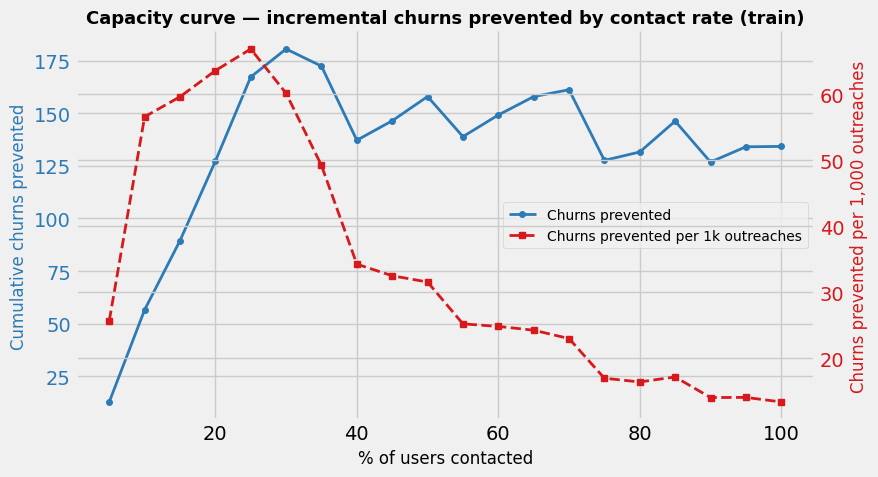

,Contact rate,incremental_churn_reduction,churns_prevented,churns_per_1k_outreaches
0,5%,0.0257,12.9,25.7
1,10%,0.0566,56.6,56.6
3,20%,0.0636,127.2,63.6
9,50%,0.0316,157.9,31.6
19,100%,0.0134,134.2,13.4


In [72]:
# ── Build and plot capacity curve (training set) ─────────────────────────
capacity_df = build_capacity_curve_data(y, treatment, train_uplift_scores, steps=20)
plot_capacity_curve(
    capacity_df,
    title="Capacity curve — incremental churns prevented by contact rate (train)",
)
plt.show()

# Show key milestones as a compact table
milestones = capacity_df[capacity_df["fraction_targeted"].isin([0.05, 0.10, 0.20, 0.30, 0.50, 1.0])].copy()
milestones["fraction_targeted"] = (milestones["fraction_targeted"] * 100).astype(int).astype(str) + "%"
milestones = milestones.rename(columns={"fraction_targeted": "Contact rate"})
display(milestones.style.format({
    "incremental_churn_reduction": "{:.4f}",
    "churns_prevented": "{:.1f}",
    "churns_per_1k_outreaches": "{:.1f}",
}).set_caption("Capacity milestones"))

### 9.5 Business summary table — slide-ready overview

One compact table combining all key business metrics at 5 %, 10 %, 20 %, 30 %, and 50 % targeting thresholds. Use this directly in stakeholder presentations: it answers *"how many users, how many churns prevented, and is the model worth it?"* — all without monetary assumptions.

In [73]:
# ── Slide-ready business summary table (training set) ────────────────────
biz_summary = build_business_metrics_summary(y, treatment, train_uplift_scores)
display(biz_summary.style.format({
    "Churn (treated)": "{:.3f}",
    "Churn (control)": "{:.3f}",
    "Incremental reduction": "{:.4f}",
    "Churns prevented": "{:.1f}",
    "Churns / 1k outreaches": "{:.1f}",
    "Lift over random": "{:.2f}",
}).set_caption("Business metrics summary — training set (realised)"))

,Top k%,N targeted,Churn (treated),Churn (control),Incremental reduction,Churns prevented,Churns / 1k outreaches,Lift over random
0,5%,500,0.232,0.258,0.0257,12.9,25.7,1.92
1,10%,1000,0.202,0.258,0.0566,56.6,56.6,4.22
2,20%,2000,0.194,0.258,0.0636,127.2,63.6,4.74
3,30%,3000,0.194,0.254,0.0602,180.5,60.2,4.48
4,50%,5000,0.209,0.241,0.0316,157.9,31.6,2.35


**Summary (Section 9).** Business metrics computed on the labelled training set demonstrate the practical value of model-based targeting. The **incremental churn reduction** quantifies how many churns the outreach prevents at each targeting level. The **lift over random** confirms that the model substantially outperforms non-targeted outreach. The **segment quality table** validates the four-quadrant segmentation: Persuadables show the highest realised uplift, while Lost Causes and Do-Not-Disturb show minimal or negative treatment benefit. The **capacity curve** identifies the optimal contact volume — the point where marginal benefit flattens — guiding resource allocation decisions. All metrics are expressed without monetary assumptions, suitable for non-technical stakeholder presentations.